<a href="https://colab.research.google.com/github/evgenii-botro/portfolio/blob/main/946b23a9_0e7b_40d7_a9f0_044586f2f4c0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Оптимизация производственных расходов металлургического комбината

---

# Описание проекта

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

## Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

## Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.






# Загрузка библиотек

In [ ]:
!pip install pyod
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

from scipy import stats as st

from sklearn.model_selection import cross_val_score, GridSearchCV, TimeSeriesSplit, train_test_split, StratifiedKFold

from sklearn.metrics import mean_absolute_error

from sklearn.preprocessing import StandardScaler

from pyod.models.knn import KNN
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

import time
from functools import partial
import warnings
warnings.filterwarnings('ignore')
RANDOM_STATE = 8726

# Предобработка данных

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
arc_path = '/content/drive/MyDrive/ds/ya_ds_projects/datasets/final_steel/final_steel/data_arc.csv'
bulk_path = '/content/drive/MyDrive/ds/ya_ds_projects/datasets/final_steel/final_steel/data_bulk.csv'
bulk_time_path = '/content/drive/MyDrive/ds/ya_ds_projects/datasets/final_steel/final_steel/data_bulk_time.csv'
gas_path = '/content/drive/MyDrive/ds/ya_ds_projects/datasets/final_steel/final_steel/data_gas.csv'
temp_path = '/content/drive/MyDrive/ds/ya_ds_projects/datasets/final_steel/final_steel/data_temp.csv'
wire_path = '/content/drive/MyDrive/ds/ya_ds_projects/datasets/final_steel/final_steel/data_wire.csv'
wire_time_path = '/content/drive/MyDrive/ds/ya_ds_projects/datasets/final_steel/final_steel/data_wire_time.csv'

In [ ]:
'''
 функция выводит информацию о датафрейме
 отображает количество уникальных значений в столбцах
 выводит функцию discribe и столбец с долей пропусков
 показывает корреляцию
 показывает названия столбцов в виде списка
 показывает количество явных дубликатов
 '''
def open_and_analyse(path):

    df = pd.read_csv(path)
    display(df.head(3))
    display(df.sample(2))
    print("-----INFO-----\n")
    display(df.info())
    print("\n-----УНИКАЛЬНЫЕ ЗНАЧЕНИЯ-----\n")
    display(df.nunique())
    print("\n-----describe-----\n")
    
    def describe(df):
        #Возвращает транспонированный describe()
        #Добавляет строку с долей пропусков для каждого столбца
        def na_part(data):
            #Агрегирует долю пропусков в объектах pandas
            part = data.isna().sum() / len(data) * 100
            return part
        return df.describe().append(df.agg([na_part])).transpose()

    display(describe(df))
    print("\n-----КОРРЕЛЯЦИЯ-----\n")
    display(df.corr())
    print("\n-----НАЗВАНИЯ СТОЛБЦОВ-----\n")
    display(df.columns)
    print(f'\n-----КОЛИЧЕСТВО ДУБЛИКАТОВ-----\n\nКоличество дубликатов в датафрейме : {df.duplicated().sum()}')
    print(f'\n-----KEY-----\n\nВ столбце KEY максимальное значение {df.key.max()}, но уникальных значений всего {df.key.nunique()}.\nЗначит в датафрейме нет {df.key.max() - df.key.nunique()} партий с данными:\n{sorted(list(set(range(1, 3242)) - set(df.key)))}.')
    return df

## Данные об электродах
**data_arc**

In [ ]:
data_arc = open_and_analyse(arc_path)
del arc_path

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
14248,3098,2019-08-27 13:06:18,2019-08-27 13:08:34,0.461064,0.330868
3494,757,2019-05-31 13:46:53,2019-05-31 13:49:16,0.530525,0.368465


-----INFO-----

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None


-----УНИКАЛЬНЫЕ ЗНАЧЕНИЯ-----



key                      3214
Начало нагрева дугой    14875
Конец нагрева дугой     14876
Активная мощность       14869
Реактивная мощность     14866
dtype: int64


-----describe-----



,count,mean,std,min,25%,50%,75%,max,na_part
key,14876.0,1615.220422,934.571502,1.000000,806.000000,1617.000000,2429.000000,3241.000000,0.0
Активная мощность,14876.0,0.670441,0.408159,0.030002,0.395297,0.555517,0.857034,3.731596,0.0
Реактивная мощность,14876.0,0.452592,5.878702,-715.504924,0.290991,0.415962,0.637371,2.676388,0.0
Начало нагрева дугой,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
Конец нагрева дугой,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0



-----КОРРЕЛЯЦИЯ-----



,key,Активная мощность,Реактивная мощность
key,1.000000,-0.021382,-0.004396
Активная мощность,-0.021382,1.000000,0.054437
Реактивная мощность,-0.004396,0.054437,1.000000



-----НАЗВАНИЯ СТОЛБЦОВ-----



Index(['key', 'Начало нагрева дугой', 'Конец нагрева дугой',
       'Активная мощность', 'Реактивная мощность'],
      dtype='object')


-----КОЛИЧЕСТВО ДУБЛИКАТОВ-----

Количество дубликатов в датафрейме : 0

-----KEY-----

В столбце KEY максимальное значение 3241, но уникальных значений всего 3214.
Значит в датафрейме нет 27 партий с данными:
[41, 42, 195, 279, 355, 382, 506, 529, 540, 607, 683, 710, 766, 1133, 1300, 1437, 2031, 2103, 2278, 2356, 2373, 2446, 2469, 2491, 2683, 3200, 3207].


In [ ]:
# приведём названия столбцов в соответсвие с нормами
data_arc.columns  = ['key', 'heatig_start', 'heating_end',
       'active_power', 'reactive_power']
data_arc.columns       

Index(['key', 'heatig_start', 'heating_end', 'active_power', 'reactive_power'], dtype='object')

Посмотрим гистограммы мощностей, чтобы изучить их распределение

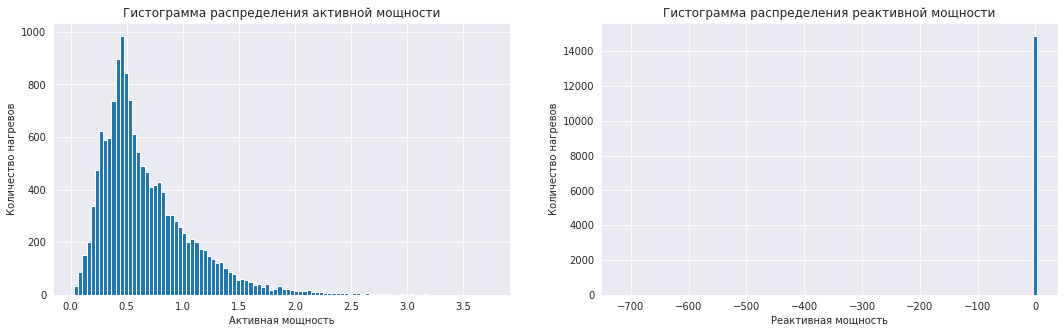

In [ ]:
fig, (ax1, ax2) = plt.subplots(
    nrows=1, ncols=2,
    figsize=(18, 5)
)
 
ax1.hist(data_arc.active_power, bins = 100)
ax1.set_title('Гистограмма распределения активной мощности')
ax1.set_xlabel('Активная мощность')
ax1.set_ylabel('Количество нагревов')
 
ax2.hist(data_arc.reactive_power, bins = 100)
ax2.set_title('Гистограмма распределения реактивной мощности')
ax2.set_xlabel('Реактивная мощность')
ax2.set_ylabel('Количество нагревов')

plt.show()

Гистограмма Реактивной мощности выглядит странно, построим ящик с усами для этого параметра.

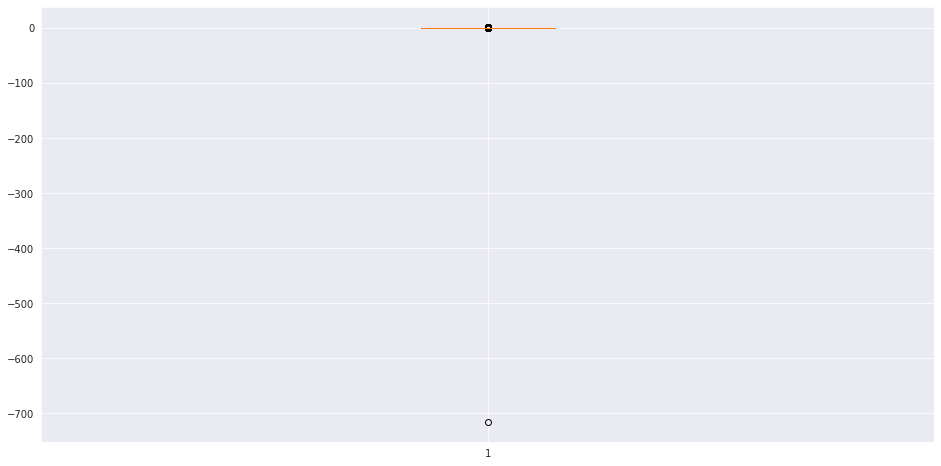

In [ ]:
plt.figure(figsize=(16, 8))
plt.boxplot(data_arc.reactive_power);

В значениях есть очевидный выброс (вероятнее всего это ошибка в показаниях), от которого лучше избавиться.

In [ ]:
data_arc = data_arc[data_arc.reactive_power > 0]

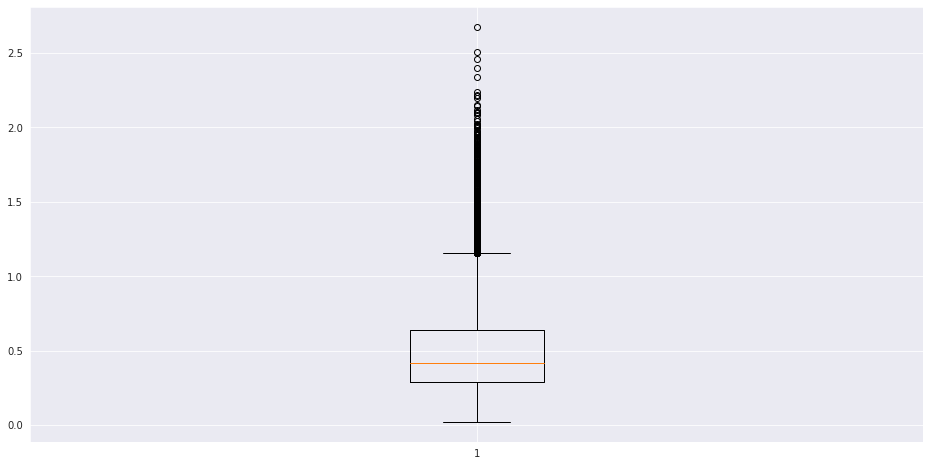

In [ ]:
plt.figure(figsize=(16, 8))
plt.boxplot(data_arc.reactive_power);

Так выглядит правдоподобнее.

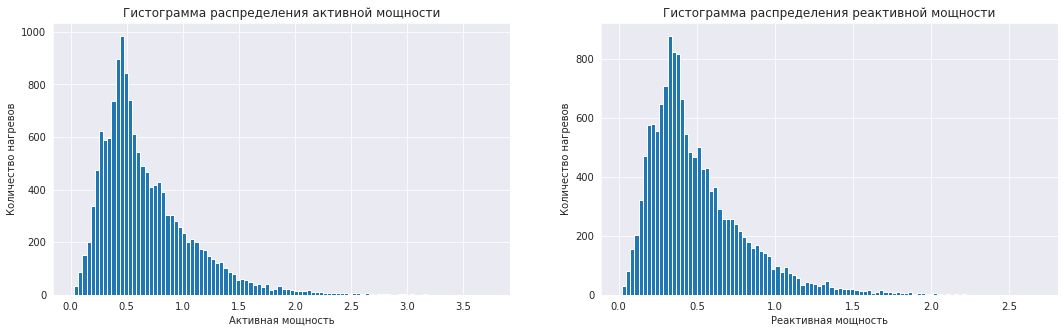

In [ ]:
fig, (ax1, ax2) = plt.subplots(
    nrows=1, ncols=2,
    figsize=(18, 5)
)
 
ax1.hist(data_arc.active_power, bins = 100)
ax1.set_title('Гистограмма распределения активной мощности')
ax1.set_xlabel('Активная мощность')
ax1.set_ylabel('Количество нагревов')
 
ax2.hist(data_arc.reactive_power, bins = 100)
ax2.set_title('Гистограмма распределения реактивной мощности')
ax2.set_xlabel('Реактивная мощность')
ax2.set_ylabel('Количество нагревов')

plt.show()

Гисторграммы практически иденитичны по форме. Посмотрим на корреляцию и матрицу рассеяния этих параметров.

,active_power,reactive_power
active_power,1.000000,0.963182
reactive_power,0.963182,1.000000


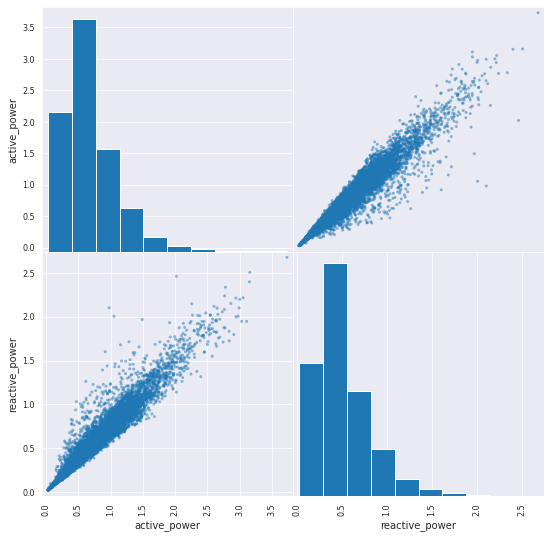

In [ ]:
pd.plotting.scatter_matrix(data_arc[['active_power', 'reactive_power']],
                           figsize=(9, 9))
data_arc[['active_power', 'reactive_power']].corr()

Действительно -  параметры очень сильно коррелируют (~0.97), поэтому и на матрице диаграмм рассеяния их зависимость выглядит как y=x, причем плотность точек убывает от начала координат к правому верхгему углу.

### Вывод

---
Для задачи могут быть важны и активная и реактивная мощность, которые очень сильно коррелируют между собой.Возможно, стоит использовать только один из этих параметров или какие-то их отношения.

В качестве *признаков* можно использовать для каждого *key* суммарную активную мощность, потому что активная мощность – это та самая мощность, потребляя которую, электронагреватель и вырабатывает тепловую энергию. 👍

## Данные о подаче сыпучих материалов (объём)
**data_bulk**

In [ ]:
data_bulk = open_and_analyse(bulk_path)
del bulk_path

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
407,433,NaN,NaN,NaN,48.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,155.0,155.0
27,28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,105.0,NaN,150.0,NaN


-----INFO-----

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None


-----УНИКАЛЬНЫЕ ЗНАЧЕНИЯ-----



key        3129
Bulk 1       47
Bulk 2       15
Bulk 3      278
Bulk 4      206
Bulk 5       55
Bulk 6      205
Bulk 7       25
Bulk 8        1
Bulk 9       10
Bulk 10      77
Bulk 11     101
Bulk 12     331
Bulk 13      14
Bulk 14     284
Bulk 15     156
dtype: int64


-----describe-----



,count,mean,std,min,25%,50%,75%,max,na_part
key,3129.0,1624.383509,933.337642,1.0,816.00,1622.0,2431.00,3241.0,0.000000
Bulk 1,252.0,39.242063,18.277654,10.0,27.00,31.0,46.00,185.0,91.946309
Bulk 2,22.0,253.045455,21.180578,228.0,242.00,251.5,257.75,325.0,99.296900
Bulk 3,1298.0,113.879045,75.483494,6.0,58.00,97.5,152.00,454.0,58.517098
Bulk 4,1014.0,104.394477,48.184126,12.0,72.00,102.0,133.00,281.0,67.593480
Bulk 5,77.0,107.025974,81.790646,11.0,70.00,86.0,132.00,603.0,97.539150
Bulk 6,576.0,118.925347,72.057776,17.0,69.75,100.0,157.00,503.0,81.591563
Bulk 7,25.0,305.600000,191.022904,47.0,155.00,298.0,406.00,772.0,99.201023
Bulk 8,1.0,49.000000,NaN,49.0,49.00,49.0,49.00,49.0,99.968041
Bulk 9,19.0,76.315789,21.720581,63.0,66.00,68.0,70.50,147.0,99.392777



-----КОРРЕЛЯЦИЯ-----



,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
key,1.000000,-0.192066,-0.038643,-0.080335,-0.101955,-0.018074,-0.063539,-0.049425,NaN,0.262741,0.288135,-0.156748,-0.030981,0.050304,-0.149840,-0.169873
Bulk 1,-0.192066,1.000000,-0.073762,0.016731,-0.040465,-0.368980,0.141745,-0.086223,NaN,NaN,-0.278055,0.461895,0.370501,1.000000,0.409188,-0.119006
Bulk 2,-0.038643,-0.073762,1.000000,NaN,0.393882,0.070350,NaN,-0.010043,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bulk 3,-0.080335,0.016731,NaN,1.000000,-0.260918,0.144410,0.253080,NaN,NaN,0.072850,-0.244532,0.137997,0.011648,-0.582598,0.026257,-0.023689
Bulk 4,-0.101955,-0.040465,0.393882,-0.260918,1.000000,-0.077214,-0.333841,0.324940,NaN,0.766565,-0.516399,NaN,0.051112,-0.311659,0.022925,0.041190
Bulk 5,-0.018074,-0.368980,0.070350,0.144410,-0.077214,1.000000,-0.511112,0.304476,NaN,NaN,NaN,NaN,0.007650,NaN,-0.256040,-0.248216
Bulk 6,-0.063539,0.141745,NaN,0.253080,-0.333841,-0.511112,1.000000,NaN,NaN,NaN,NaN,-0.104251,-0.079822,0.844690,0.154429,-0.038363
Bulk 7,-0.049425,-0.086223,-0.010043,NaN,0.324940,0.304476,NaN,1.000000,NaN,NaN,NaN,NaN,0.538671,NaN,1.000000,NaN
Bulk 8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bulk 9,0.262741,NaN,NaN,0.072850,0.766565,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,0.946954,NaN,-0.479974,NaN



-----НАЗВАНИЯ СТОЛБЦОВ-----



Index(['key', 'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6',
       'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12',
       'Bulk 13', 'Bulk 14', 'Bulk 15'],
      dtype='object')


-----КОЛИЧЕСТВО ДУБЛИКАТОВ-----

Количество дубликатов в датафрейме : 0

-----KEY-----

В столбце KEY максимальное значение 3241, но уникальных значений всего 3129.
Значит в датафрейме нет 112 партий с данными:
[41, 42, 51, 52, 53, 54, 55, 56, 72, 80, 81, 110, 151, 188, 195, 225, 269, 302, 330, 331, 332, 343, 350, 355, 382, 506, 529, 540, 607, 661, 683, 710, 766, 830, 874, 931, 933, 934, 960, 961, 964, 966, 983, 984, 1062, 1105, 1133, 1221, 1268, 1300, 1334, 1402, 1437, 1517, 1518, 1535, 1566, 1623, 1656, 1783, 1818, 1911, 1959, 1974, 1979, 2009, 2010, 2031, 2043, 2056, 2103, 2195, 2196, 2197, 2198, 2216, 2217, 2231, 2278, 2310, 2356, 2373, 2390, 2408, 2434, 2446, 2460, 2468, 2469, 2471, 2491, 2595, 2599, 2600, 2608, 2625, 2628, 2683, 2738, 2739, 2816, 2821, 2863, 2884, 2891, 3018, 3026, 3047, 3182, 3200, 3207, 3216].


In [ ]:
# приведём названия столбцов в соответсвие с нормами
data_bulk.columns  = ['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15']
data_bulk.columns       

Index(['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15'],
      dtype='object')

Судя по количеству записей, для каждой партии приведено суммарный объем по каждому сыпучему материалу.  
Пропуски, видимо, означают, что этого материала не подавалось. 

In [ ]:
# посмотрим статистические данные по таблице
data_bulk[data_bulk.columns.difference(['key'])].describe().sort_values('mean', axis = 1, ascending = False).transpose()

,count,mean,std,min,25%,50%,75%,max
bulk_7,25.0,305.600000,191.022904,47.0,155.00,298.0,406.00,772.0
bulk_12,2450.0,260.471020,120.649269,53.0,204.00,208.0,316.00,1849.0
bulk_2,22.0,253.045455,21.180578,228.0,242.00,251.5,257.75,325.0
bulk_13,18.0,181.111111,46.088009,151.0,153.25,155.5,203.50,305.0
bulk_14,2806.0,170.284747,65.868652,16.0,119.00,151.0,205.75,636.0
bulk_15,2248.0,160.513345,51.765319,1.0,105.00,160.0,205.00,405.0
bulk_6,576.0,118.925347,72.057776,17.0,69.75,100.0,157.00,503.0
bulk_3,1298.0,113.879045,75.483494,6.0,58.00,97.5,152.00,454.0
bulk_5,77.0,107.025974,81.790646,11.0,70.00,86.0,132.00,603.0
bulk_4,1014.0,104.394477,48.184126,12.0,72.00,102.0,133.00,281.0


По объему в среднем больше всего добавляют материалов 12, 14, 15; меньше всего - 13, 9, 8

### Вывод

---
В разные партии добавляют разное количество материалов, разный их объем, а 112 партий остались чистыми.

В качестве признаков можно использовать для каждого key объем по каждому добавленному материалу, а также их суммарный объем и общее количество (при условии что эти матриалы добавлялись до полследнего измерения температуры)

## Данные о подаче сыпучих материалов (время) 
**data_bulk_time**

In [ ]:
data_bulk_time = open_and_analyse(bulk_time_path)
del bulk_time_path

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
2137,2213,NaN,NaN,NaN,2019-07-27 01:15:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-07-27 01:05:02,NaN,2019-07-27 01:05:02,2019-07-27 01:05:02
1562,1620,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-06-30 11:52:59,NaN,2019-06-30 11:52:59,2019-06-30 11:52:59


-----INFO-----

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


None


-----УНИКАЛЬНЫЕ ЗНАЧЕНИЯ-----



key        3129
Bulk 1      252
Bulk 2       22
Bulk 3     1298
Bulk 4     1014
Bulk 5       77
Bulk 6      576
Bulk 7       25
Bulk 8        1
Bulk 9       19
Bulk 10     176
Bulk 11     177
Bulk 12    2450
Bulk 13      18
Bulk 14    2806
Bulk 15    2248
dtype: int64


-----describe-----



,count,mean,std,min,25%,50%,75%,max,na_part
key,3129.0,1624.383509,933.337642,1.0,816.0,1622.0,2431.0,3241.0,0.000000
Bulk 1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,91.946309
Bulk 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99.296900
Bulk 3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58.517098
Bulk 4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,67.593480
Bulk 5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,97.539150
Bulk 6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81.591563
Bulk 7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99.201023
Bulk 8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99.968041
Bulk 9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99.392777



-----КОРРЕЛЯЦИЯ-----



,key
key,1.0



-----НАЗВАНИЯ СТОЛБЦОВ-----



Index(['key', 'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6',
       'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12',
       'Bulk 13', 'Bulk 14', 'Bulk 15'],
      dtype='object')


-----КОЛИЧЕСТВО ДУБЛИКАТОВ-----

Количество дубликатов в датафрейме : 0

-----KEY-----

В столбце KEY максимальное значение 3241, но уникальных значений всего 3129.
Значит в датафрейме нет 112 партий с данными:
[41, 42, 51, 52, 53, 54, 55, 56, 72, 80, 81, 110, 151, 188, 195, 225, 269, 302, 330, 331, 332, 343, 350, 355, 382, 506, 529, 540, 607, 661, 683, 710, 766, 830, 874, 931, 933, 934, 960, 961, 964, 966, 983, 984, 1062, 1105, 1133, 1221, 1268, 1300, 1334, 1402, 1437, 1517, 1518, 1535, 1566, 1623, 1656, 1783, 1818, 1911, 1959, 1974, 1979, 2009, 2010, 2031, 2043, 2056, 2103, 2195, 2196, 2197, 2198, 2216, 2217, 2231, 2278, 2310, 2356, 2373, 2390, 2408, 2434, 2446, 2460, 2468, 2469, 2471, 2491, 2595, 2599, 2600, 2608, 2625, 2628, 2683, 2738, 2739, 2816, 2821, 2863, 2884, 2891, 3018, 3026, 3047, 3182, 3200, 3207, 3216].


In [ ]:
# приведём названия столбцов в соответсвие с нормами
data_bulk_time.columns  = ['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15']
data_bulk_time.columns       

Index(['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15'],
      dtype='object')

### Вывод

___
Таблица может служить для связи данных об объеме подачи сыпучих материалов с таблицами данных об электродах (нагреве), измерениях температуры и о проволочных материалах (время) через общий ключ - время. 

## Данные о продувке сплава газом
**data_gas**

In [ ]:
data_gas = open_and_analyse(gas_path)
del gas_path

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793


,key,Газ 1
2901,2904,7.574892
3074,3077,10.622387


-----INFO-----

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None


-----УНИКАЛЬНЫЕ ЗНАЧЕНИЯ-----



key      3239
Газ 1    3239
dtype: int64


-----describe-----



,count,mean,std,min,25%,50%,75%,max,na_part
key,3239.0,1621.861377,935.386334,1.000000,812.500000,1622.000000,2431.500000,3241.00000,0.0
Газ 1,3239.0,11.002062,6.220327,0.008399,7.043089,9.836267,13.769915,77.99504,0.0



-----КОРРЕЛЯЦИЯ-----



,key,Газ 1
key,1.000000,-0.040655
Газ 1,-0.040655,1.000000



-----НАЗВАНИЯ СТОЛБЦОВ-----



Index(['key', 'Газ 1'], dtype='object')


-----КОЛИЧЕСТВО ДУБЛИКАТОВ-----

Количество дубликатов в датафрейме : 0

-----KEY-----

В столбце KEY максимальное значение 3241, но уникальных значений всего 3239.
Значит в датафрейме нет 2 партий с данными:
[193, 259].


In [ ]:
# приведём названия столбцов в соответсвие с нормами
data_gas.columns  = ['key','gas_1']
data_gas.columns       

Index(['key', 'gas_1'], dtype='object')

Каждая партия в таблице встречается только 1 раз, значит это суммарная величина продува со всех этапов; газом продувались не все партии.  
В значения для партий 193 и 259 занесем 0, так как для них суммарный объем газа и равен 0.

In [ ]:
data_gas.loc[len(data_gas)] = [193, 0]
data_gas.loc[len(data_gas)] = [259, 0]
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3241 entries, 0 to 3240
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3241 non-null   int64  
 1   gas_1   3241 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 76.0 KB


Посмотрим на распределение на гистограмме.

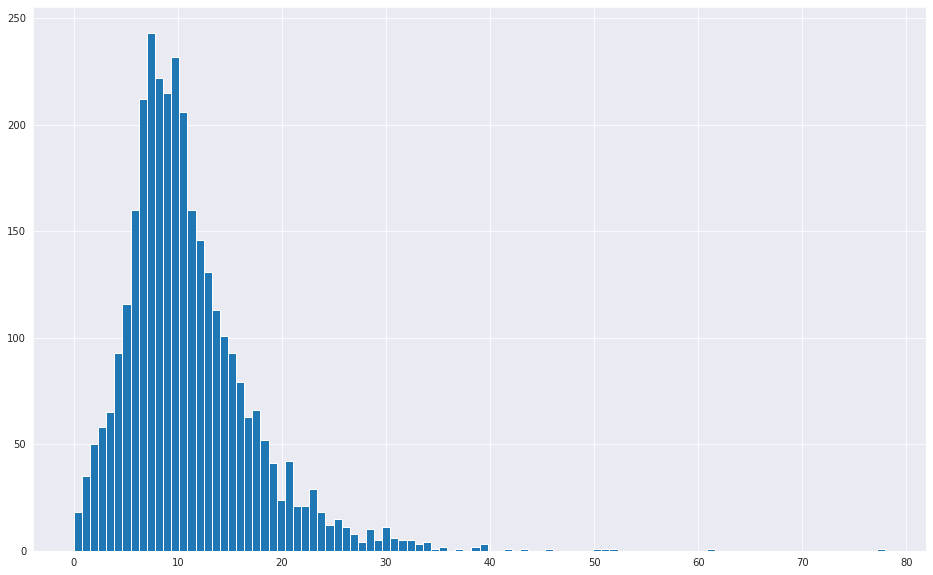

In [ ]:
data_gas.gas_1.hist(bins=100, figsize=(16,10));

Значения распределены практически нормально, пик на 6-11, сдвинутое влево.

### Вывод

___

В качестве признаков можно использовать для каждого key общий объем затраченного газа.

## Результаты измерения температуры
**data_temp**

In [ ]:
data_temp = open_and_analyse(temp_path)
del temp_path

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0


,key,Время замера,Температура
4370,870,2019-06-04 16:47:26,1586.0
10982,2229,2019-07-27 13:46:38,1607.0


-----INFO-----

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


None


-----УНИКАЛЬНЫЕ ЗНАЧЕНИЯ-----



key              3216
Время замера    15907
Температура       175
dtype: int64


-----describe-----



,count,mean,std,min,25%,50%,75%,max,na_part
key,15907.0,1607.88087,942.212073,1.0,790.0,1618.0,2427.0,3241.0,0.000000
Температура,13006.0,1591.84092,21.375851,1191.0,1581.0,1591.0,1601.0,1705.0,18.237254
Время замера,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000



-----КОРРЕЛЯЦИЯ-----



,key,Температура
key,1.000000,-0.046895
Температура,-0.046895,1.000000



-----НАЗВАНИЯ СТОЛБЦОВ-----



Index(['key', 'Время замера', 'Температура'], dtype='object')


-----КОЛИЧЕСТВО ДУБЛИКАТОВ-----

Количество дубликатов в датафрейме : 0

-----KEY-----

В столбце KEY максимальное значение 3241, но уникальных значений всего 3216.
Значит в датафрейме нет 25 партий с данными:
[41, 42, 355, 382, 506, 529, 540, 607, 683, 710, 766, 1133, 1300, 1437, 2031, 2103, 2278, 2356, 2373, 2446, 2469, 2491, 2683, 3200, 3207].


In [ ]:
# приведём названия столбцов в соответсвие с нормами
data_temp.columns  = ['key', 'measuring_time', 'temp']
data_temp.columns       

Index(['key', 'measuring_time', 'temp'], dtype='object')

In [ ]:
print(f'Количество пропусков в столбце температура: {data_temp.temp.isna().sum()}')

Количество пропусков в столбце температура: 2901


Пропуски пока не трогаем, так как в этой таблице наш целевой признак.  
Посмотрим на распределение значений в столбце с температурой.

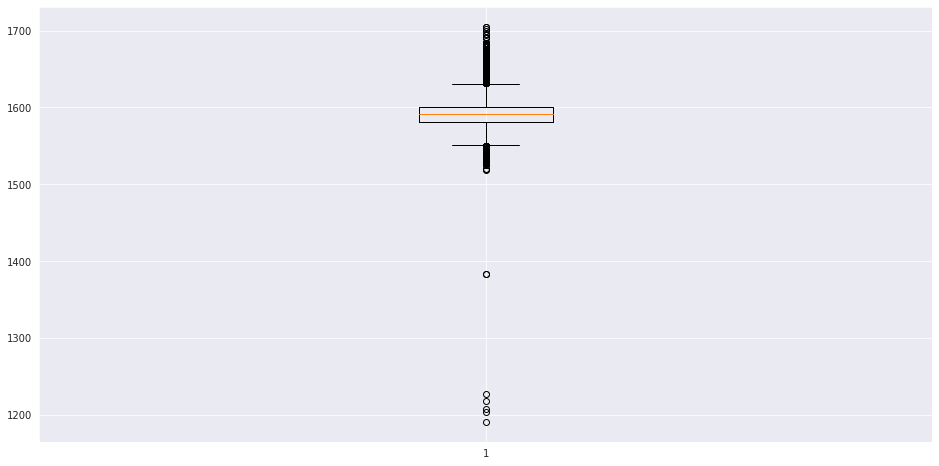

In [ ]:
plt.figure(figsize=(16, 8))
plt.boxplot(data_temp.temp.dropna());

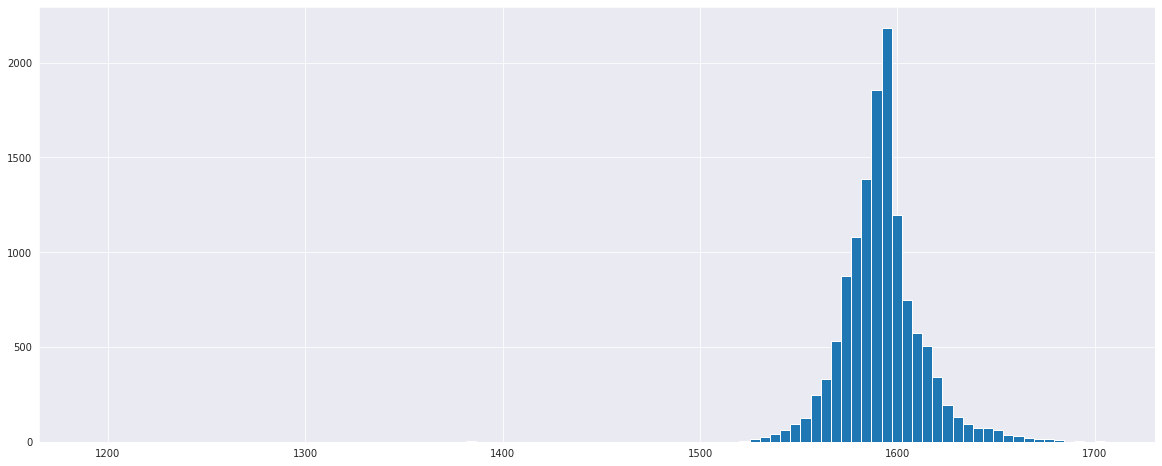

In [ ]:
data_temp.temp.hist(bins=100, figsize=(20,8));

Распределение нормальное.  
Есть подозрительны значения, но пока не будем от них избавляться, так как в этой таблице наш целевой признак, а наша модель должна уметь работать со всеми данными.

### Вывод

---
В таблице есть значащий столбец, часть значений в котором станет целевым признаком в нашей задаче - значение последней измеренной температуры. В нем есть выбросы и пропуски, но от них пока не избавляемся. Столбец со временем измерения связывает таблицу с некоторыми остальными таблицами.

В качестве признаков можно использовать для каждого key результат первого измерения температуры.  
Целевой признак - результат последнего измерения.

## Данные о проволочных материалах (объём)
**data_wire**

In [ ]:
data_wire = open_and_analyse(wire_path)
del wire_path

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
1195,1263,140.119198,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
388,420,181.350006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


-----INFO-----

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None


-----УНИКАЛЬНЫЕ ЗНАЧЕНИЯ-----



key       3081
Wire 1    2251
Wire 2     713
Wire 3      56
Wire 4      14
Wire 5       1
Wire 6      69
Wire 7      10
Wire 8      13
Wire 9      25
dtype: int64


-----describe-----



,count,mean,std,min,25%,50%,75%,max,na_part
key,3081.0,1623.426485,932.996726,1.000000,823.000000,1619.000000,2434.000000,3241.000000,0.000000
Wire 1,3055.0,100.895853,42.012518,1.918800,72.115684,100.158234,126.060483,330.314424,0.843882
Wire 2,1079.0,50.577323,39.320216,0.030160,20.193680,40.142956,70.227558,282.780152,64.978903
Wire 3,63.0,189.482681,99.513444,0.144144,95.135044,235.194977,276.252014,385.008668,97.955209
Wire 4,14.0,57.442841,28.824667,24.148801,40.807002,45.234282,76.124619,113.231044,99.545602
Wire 5,1.0,15.132000,NaN,15.132000,15.132000,15.132000,15.132000,15.132000,99.967543
Wire 6,73.0,48.016974,33.919845,0.034320,25.053600,42.076324,64.212723,180.454575,97.630639
Wire 7,11.0,10.039007,8.610584,0.234208,6.762756,9.017009,11.886057,32.847674,99.642973
Wire 8,19.0,53.625193,16.881728,45.076721,46.094879,46.279999,48.089603,102.762401,99.383317
Wire 9,29.0,34.155752,19.931616,4.622800,22.058401,30.066399,43.862003,90.053604,99.058747



-----КОРРЕЛЯЦИЯ-----



,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
key,1.000000,-0.083352,-0.005461,-0.084460,0.389064,NaN,0.082274,0.578898,0.323891,-0.012200
Wire 1,-0.083352,1.000000,-0.030892,0.724370,0.054001,NaN,-0.280807,-0.035072,0.068697,0.010104
Wire 2,-0.005461,-0.030892,1.000000,-0.081852,NaN,NaN,-0.265706,NaN,0.250477,0.011019
Wire 3,-0.084460,0.724370,-0.081852,1.000000,0.069854,NaN,-0.221602,-0.056948,NaN,NaN
Wire 4,0.389064,0.054001,NaN,0.069854,1.000000,NaN,0.237456,-0.404865,NaN,NaN
Wire 5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Wire 6,0.082274,-0.280807,-0.265706,-0.221602,0.237456,NaN,1.000000,-0.224093,NaN,NaN
Wire 7,0.578898,-0.035072,NaN,-0.056948,-0.404865,NaN,-0.224093,1.000000,NaN,NaN
Wire 8,0.323891,0.068697,0.250477,NaN,NaN,NaN,NaN,NaN,1.000000,NaN
Wire 9,-0.012200,0.010104,0.011019,NaN,NaN,NaN,NaN,NaN,NaN,1.000000



-----НАЗВАНИЯ СТОЛБЦОВ-----



Index(['key', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6',
       'Wire 7', 'Wire 8', 'Wire 9'],
      dtype='object')


-----КОЛИЧЕСТВО ДУБЛИКАТОВ-----

Количество дубликатов в датафрейме : 0

-----KEY-----

В столбце KEY максимальное значение 3241, но уникальных значений всего 3081.
Значит в датафрейме нет 160 партий с данными:
[41, 42, 51, 52, 53, 54, 55, 56, 81, 82, 83, 84, 85, 88, 109, 195, 197, 209, 210, 211, 212, 269, 330, 331, 332, 355, 375, 376, 377, 378, 382, 506, 529, 540, 607, 683, 710, 711, 712, 713, 714, 715, 744, 748, 754, 755, 766, 796, 797, 798, 799, 800, 841, 929, 930, 931, 932, 933, 934, 1102, 1103, 1104, 1105, 1106, 1107, 1133, 1184, 1300, 1379, 1380, 1437, 1525, 1526, 1527, 1528, 1564, 1565, 1566, 1646, 1743, 1744, 1745, 1746, 1747, 1748, 1758, 1817, 1818, 1836, 1946, 1977, 1978, 1979, 2010, 2031, 2043, 2103, 2195, 2196, 2197, 2198, 2214, 2215, 2216, 2217, 2218, 2219, 2236, 2238, 2278, 2356, 2360, 2367, 2368, 2369, 2370, 2373, 2388, 2389, 2390, 2391, 2392, 2393, 2446, 2469, 2491, 2624, 2625, 2626, 2627, 2628, 2629, 2683, 2788, 2789, 2790, 2791, 2792, 2814, 2815, 2846, 2847, 2848, 28

In [ ]:
# приведём названия столбцов в соответсвие с нормами
data_wire.columns  = ['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6',
       'wire_7', 'wire_8', 'wire_9']
data_wire.columns       

Index(['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6',
       'wire_7', 'wire_8', 'wire_9'],
      dtype='object')

In [ ]:
data_wire.columns   

Index(['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6',
       'wire_7', 'wire_8', 'wire_9'],
      dtype='object')

Эти данные аналогичны по структуре данным о подаче сыпучих материалов (объём). Проведем те же исследования.

Столбцы `wire_1` и `wire_3` сильно коррелируют. Обратим на это внимание в ходе работы.

Номера партий не дублируются.  
Пропуски, видимо, означают, что этого материала не подавалось.

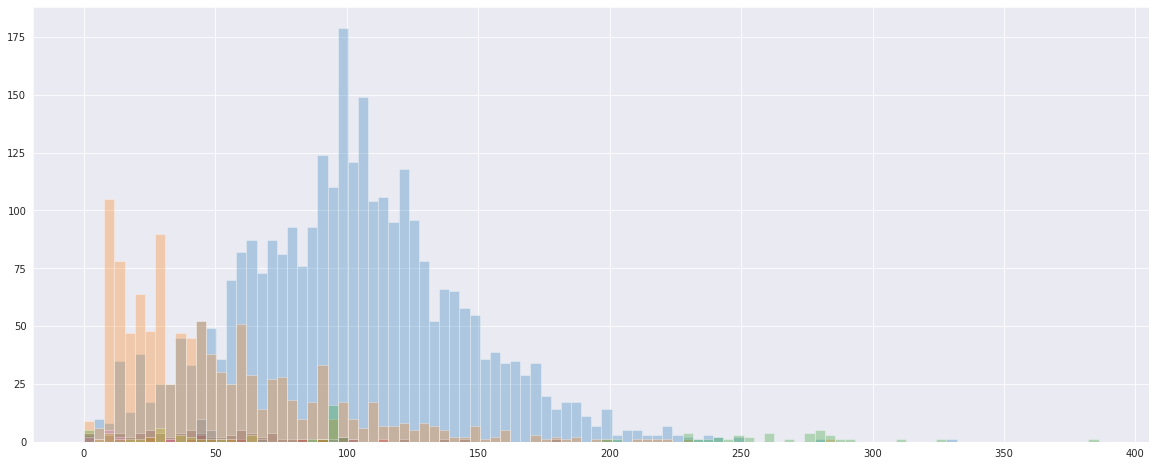

In [ ]:
for column in data_wire.columns.difference(['key']):
    data_wire[column].hist(bins=100, figsize=(20,8), alpha=0.3, range=(0.03, 386))

### Вывод

---
В разные партии добавляют разное количество материалов в разном объёме, а 160 партий остались чистыми.

В качестве признаков можно использовать для каждого key объем по каждому добавленному материалу, а также их суммарный объем и общее количество (при условии что эти матриалы добавлялись до полследнего измерения температуры).

## Данные о проволочных материалах (время)
**data_wire_time**

In [ ]:
data_wire_time = open_and_analyse(wire_time_path)
del wire_time_path

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
1939,2035,2019-07-21 01:49:41,2019-07-21 01:51:09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
538,573,2019-05-24 14:02:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


-----INFO-----

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


None


-----УНИКАЛЬНЫЕ ЗНАЧЕНИЯ-----



key       3081
Wire 1    3055
Wire 2    1079
Wire 3      63
Wire 4      14
Wire 5       1
Wire 6      73
Wire 7      11
Wire 8      19
Wire 9      29
dtype: int64


-----describe-----



,count,mean,std,min,25%,50%,75%,max,na_part
key,3081.0,1623.426485,932.996726,1.0,823.0,1619.0,2434.0,3241.0,0.000000
Wire 1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.843882
Wire 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.978903
Wire 3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,97.955209
Wire 4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99.545602
Wire 5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99.967543
Wire 6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,97.630639
Wire 7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99.642973
Wire 8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99.383317
Wire 9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99.058747



-----КОРРЕЛЯЦИЯ-----



,key
key,1.0



-----НАЗВАНИЯ СТОЛБЦОВ-----



Index(['key', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6',
       'Wire 7', 'Wire 8', 'Wire 9'],
      dtype='object')


-----КОЛИЧЕСТВО ДУБЛИКАТОВ-----

Количество дубликатов в датафрейме : 0

-----KEY-----

В столбце KEY максимальное значение 3241, но уникальных значений всего 3081.
Значит в датафрейме нет 160 партий с данными:
[41, 42, 51, 52, 53, 54, 55, 56, 81, 82, 83, 84, 85, 88, 109, 195, 197, 209, 210, 211, 212, 269, 330, 331, 332, 355, 375, 376, 377, 378, 382, 506, 529, 540, 607, 683, 710, 711, 712, 713, 714, 715, 744, 748, 754, 755, 766, 796, 797, 798, 799, 800, 841, 929, 930, 931, 932, 933, 934, 1102, 1103, 1104, 1105, 1106, 1107, 1133, 1184, 1300, 1379, 1380, 1437, 1525, 1526, 1527, 1528, 1564, 1565, 1566, 1646, 1743, 1744, 1745, 1746, 1747, 1748, 1758, 1817, 1818, 1836, 1946, 1977, 1978, 1979, 2010, 2031, 2043, 2103, 2195, 2196, 2197, 2198, 2214, 2215, 2216, 2217, 2218, 2219, 2236, 2238, 2278, 2356, 2360, 2367, 2368, 2369, 2370, 2373, 2388, 2389, 2390, 2391, 2392, 2393, 2446, 2469, 2491, 2624, 2625, 2626, 2627, 2628, 2629, 2683, 2788, 2789, 2790, 2791, 2792, 2814, 2815, 2846, 2847, 2848, 28

In [ ]:
# приведём названия столбцов в соответсвие с нормами
data_wire_time.columns  = ['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6',
       'wire_7', 'wire_8', 'wire_9']
data_wire_time.columns       

Index(['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6',
       'wire_7', 'wire_8', 'wire_9'],
      dtype='object')

### Вывод

---
Таблица может служить для связи данных об объеме подачи проволочных материалов с таблицами данных об электродах (нагреве), измерениях температуры и о сыпучих материалах (время) через общий ключ - время. Данные в порядке.

## Вывод по предобработке данных


- Пропуски значений в столбцах. Возможно это ошибка датчика, который не передал информацию или отсутствие действия/замера на этой стадии. В данных о подаче сыпучих и проволочных материалов предположили, что пропуски являются отсутствием подачи и заменили нулями.  
- В таблицах `data_bulk` и `data_wire` указаны 15 и 9 столбцов о различных материалах. Это значит, что в каждую партию может идти определенный набор из них и только единицам требуется использование всех возможных материалов.
- В таблицах разное количество уникальных номеров партии **key**. Это может означать, что данные по партии могут быть утеряны или над ней не выполнялся технологический этап.
- Есть столбцы, которые могут не использовать тип float, так как хранят только целые числа.
- Разноязычные названия столбцов. Имена столбцов нужно привели к английском языку прописными буквами и избавились от пробелов.
- Данные требуют обработки и группировки по признаку **key*. Данные об активной и реактивной мощности распределены нормально со смещением влево, данные о температуре распределены нормально без смещения.

# План действий

- [x] Загрузить данные.  
Выполнить исследовательский анализ и первичную предобработку.
- [x] Подготовить данные.  
Изменить типы данных, определить и использовать номера партий, у которых есть замеры по температуре.
- [x] Подготовить признаки.  
- [x] Проверить на мультиколлинеарность.
Составить единую таблицу со всеми данными для модели.
  - [x] Выделить целевой признак как последний замер в серии замеров. Разделить на features и target со смешиванием данных.
- [x] Выбрать модели.  
Использование и обучение регрессионных моделей.
- [x] Оценить эффективность моделей на тестовой выборке.
- [x] Составить сводную таблицу и выбрать лучшую модель.


 



# Подготовка данных

- Найдем суммы значений активной мощности для каждого key.
- Найдем все записи по температурам, где есть минимум два значения температуры, и создадим новую таблицу из первого и последнего замера.
- Значения столбца key переведем в индексы датафреймов.
- Приведем типы данных для ускорения работы.
- Разобьем данные на train/test в соотношении 75/25.

Составим из таблицы `data_arc` сгрупированную таблицу `data_arc_sum` по key для дальнейшего объединения данных. По факту, чем больше энергии было затрачено на нагрев, тем больше должна быть темпереатура.

In [ ]:
data_arc_sum = pd.pivot_table(
                              data_arc,
                              values=['active_power'],
                              index='key',
                              aggfunc=np.sum
                              )
data_arc_sum.columns = ['sum_active_power']
data_arc_sum.head()

,sum_active_power
key,
1,4.878147
2,3.052598
3,2.525882
4,3.209250
5,3.347173


Удалим из таблицы партии *key*, которые не подходят по следующим условиям:

- нет финального замера, когда температуру замеряли до окончания последней операции нагрева дугой
- только один замер температуры

In [ ]:
bad_keys = []
for key in list(data_temp.key.unique()):
    try:
        if (
            (data_temp[data_temp.key == key]['measuring_time'].max() < data_arc[data_arc.key == key]['heating_end'].max())
           or
            (data_temp[data_temp.key == key]['measuring_time'].max() ==  data_temp[data_temp.key == key]['measuring_time'].min())
           ):
           
            bad_keys.append(key)
    except:
        bad_keys.append(key)
display(len(bad_keys))
# использовал print специально, чтобы выводилось строкой, а не столбцом
print(bad_keys)

171

[11, 38, 43, 51, 64, 69, 73, 81, 177, 179, 180, 182, 185, 195, 213, 216, 220, 222, 267, 271, 279, 293, 296, 297, 321, 325, 326, 444, 445, 448, 453, 456, 470, 471, 472, 491, 535, 562, 586, 587, 588, 590, 592, 593, 596, 616, 638, 641, 704, 731, 733, 741, 757, 786, 869, 870, 874, 878, 928, 929, 932, 934, 997, 1057, 1060, 1152, 1153, 1161, 1232, 1313, 1316, 1341, 1371, 1381, 1402, 1433, 1458, 1461, 1464, 1493, 1505, 1558, 1578, 1618, 1622, 1623, 1624, 1639, 1657, 1683, 1685, 1712, 1713, 1720, 1724, 1811, 1813, 1837, 1872, 1873, 1876, 1946, 1949, 1964, 1966, 1987, 1989, 1990, 1992, 1993, 1994, 2053, 2078, 2138, 2140, 2142, 2143, 2152, 2211, 2221, 2261, 2263, 2265, 2300, 2303, 2389, 2390, 2393, 2398, 2425, 2427, 2451, 2457, 2522, 2540, 2543, 2544, 2572, 2601, 2604, 2606, 2667, 2670, 2671, 2695, 2698, 2736, 2743, 2787, 2808, 2809, 2814, 2838, 2842, 2843, 2862, 2898, 2951, 2960, 2988, 3044, 3047, 3146, 3153, 3156, 3187, 3204, 3209, 3211, 3212, 3216]


In [ ]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   key             15907 non-null  int64  
 1   measuring_time  15907 non-null  object 
 2   temp            13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


In [ ]:
# удалим все строки с пропусками
data_temp = data_temp.query('key not in @bad_keys').dropna()
del(bad_keys)
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12381 entries, 0 to 15902
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   key             12381 non-null  int64  
 1   measuring_time  12381 non-null  object 
 2   temp            12381 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 386.9+ KB


In [ ]:
count_of_bad_keys = (data_temp.key.value_counts() < 2).sum() 
good_keys = list(data_temp.key.value_counts().index[:-count_of_bad_keys])
data_temp = data_temp.query('key in @good_keys')
del(good_keys)
data_temp.key.value_counts()

1513    16
46      16
44      16
1214    16
1689    15
        ..
1836     2
744      2
273      2
830      2
951      2
Name: key, Length: 2344, dtype: int64

In [ ]:
# получим срез со значениями времени начального и конечного замера
data_temp.columns = ['key', 'time', 'temp']
pt_data_temp = pd.pivot_table(
                              data_temp,
                              index='key',
                              values='time',
                              aggfunc={'time': [np.min, np.max]}
                              )
pt_data_temp

,amax,amin
key,,
1,2019-05-03 11:30:39,2019-05-03 11:16:18
2,2019-05-03 11:59:12,2019-05-03 11:37:27
3,2019-05-03 12:34:57,2019-05-03 12:13:17
4,2019-05-03 12:59:25,2019-05-03 12:52:57
5,2019-05-03 13:36:01,2019-05-03 13:23:19
...,...,...
2495,2019-08-06 00:54:42,2019-08-06 00:35:45
2496,2019-08-06 01:29:52,2019-08-06 01:02:54
2497,2019-08-06 01:53:50,2019-08-06 01:41:53


In [ ]:
pt_data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2344 entries, 1 to 2499
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   amax    2344 non-null   object
 1   amin    2344 non-null   object
dtypes: object(2)
memory usage: 54.9+ KB


In [ ]:
# cформируем новый срез на основе времени
start_time_list = list(pt_data_temp['amin'])
end_time_list = list(pt_data_temp['amax'])

data_temp_start_temp = data_temp.query('time in @start_time_list').set_index('key')
data_temp_end_temp = data_temp.query('time in @end_time_list').set_index('key')

data_temp_final = data_temp_start_temp.copy()
data_temp_final.columns = ['time','start_temp']
data_temp_final['end_temp'] = data_temp_end_temp['temp']
data_temp_final = data_temp_final.drop('time', axis=1)

del(start_time_list, end_time_list, data_temp_start_temp, data_temp_end_temp)
data_temp_final.head()

,start_temp,end_temp
key,,
1,1571.0,1613.0
2,1581.0,1602.0
3,1596.0,1599.0
4,1601.0,1625.0
5,1576.0,1602.0


Для объединения нам потребуются датафреймы `data_arc_sum`, `data_temp_final`, `data_bulk`, `data_gas` и `data_wire`. В каждой таблице преобразуем значениz столбца *key* в индекс.

In [ ]:
data_bulk = data_bulk.set_index('key')
data_gas = data_gas.set_index('key')
data_wire = data_wire.set_index('key')

Наша цель - предсказывать значение end_temp. Удалим партии, где нет информации о температуре.

In [ ]:
data_steel = pd.concat([data_arc_sum, data_temp_final, data_bulk, data_gas, data_wire], axis=1, sort=False).dropna(subset=['end_temp'])
data_steel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2344 entries, 1 to 2499
Data columns (total 28 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   sum_active_power  2344 non-null   float64
 1   start_temp        2344 non-null   float64
 2   end_temp          2344 non-null   float64
 3   bulk_1            189 non-null    float64
 4   bulk_2            13 non-null     float64
 5   bulk_3            931 non-null    float64
 6   bulk_4            758 non-null    float64
 7   bulk_5            53 non-null     float64
 8   bulk_6            433 non-null    float64
 9   bulk_7            13 non-null     float64
 10  bulk_8            1 non-null      float64
 11  bulk_9            13 non-null     float64
 12  bulk_10           130 non-null    float64
 13  bulk_11           124 non-null    float64
 14  bulk_12           1797 non-null   float64
 15  bulk_13           13 non-null     float64
 16  bulk_14           2043 non-null   float64


In [ ]:
# cтолбец wire_5 удалим из-за отсуствия записей
data_steel = data_steel.drop('wire_5',axis=1)
data_steel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2344 entries, 1 to 2499
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   sum_active_power  2344 non-null   float64
 1   start_temp        2344 non-null   float64
 2   end_temp          2344 non-null   float64
 3   bulk_1            189 non-null    float64
 4   bulk_2            13 non-null     float64
 5   bulk_3            931 non-null    float64
 6   bulk_4            758 non-null    float64
 7   bulk_5            53 non-null     float64
 8   bulk_6            433 non-null    float64
 9   bulk_7            13 non-null     float64
 10  bulk_8            1 non-null      float64
 11  bulk_9            13 non-null     float64
 12  bulk_10           130 non-null    float64
 13  bulk_11           124 non-null    float64
 14  bulk_12           1797 non-null   float64
 15  bulk_13           13 non-null     float64
 16  bulk_14           2043 non-null   float64


In [ ]:
# все значения Nan заменим нулями в соответствии с нашими наблюдениями
# приведем типы столбцов 'start_temp', 'end_temp' и 'bulk' к целочисленному типу
data_steel = data_steel.fillna(0)
data_steel['start_temp'] = pd.to_numeric(data_steel['start_temp'], downcast='integer')
data_steel['end_temp'] = pd.to_numeric(data_steel['end_temp'], downcast='integer')
for i in range(1,16):
    data_steel[f'bulk_{i}'] = pd.to_numeric(data_steel[f'bulk_{i}'], downcast='integer')
data_steel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2344 entries, 1 to 2499
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   sum_active_power  2344 non-null   float64
 1   start_temp        2344 non-null   int16  
 2   end_temp          2344 non-null   int16  
 3   bulk_1            2344 non-null   int16  
 4   bulk_2            2344 non-null   int16  
 5   bulk_3            2344 non-null   int16  
 6   bulk_4            2344 non-null   int16  
 7   bulk_5            2344 non-null   int16  
 8   bulk_6            2344 non-null   int16  
 9   bulk_7            2344 non-null   int16  
 10  bulk_8            2344 non-null   int8   
 11  bulk_9            2344 non-null   int16  
 12  bulk_10           2344 non-null   int16  
 13  bulk_11           2344 non-null   int16  
 14  bulk_12           2344 non-null   int16  
 15  bulk_13           2344 non-null   int16  
 16  bulk_14           2344 non-null   int16  


## Изучим распределение данных

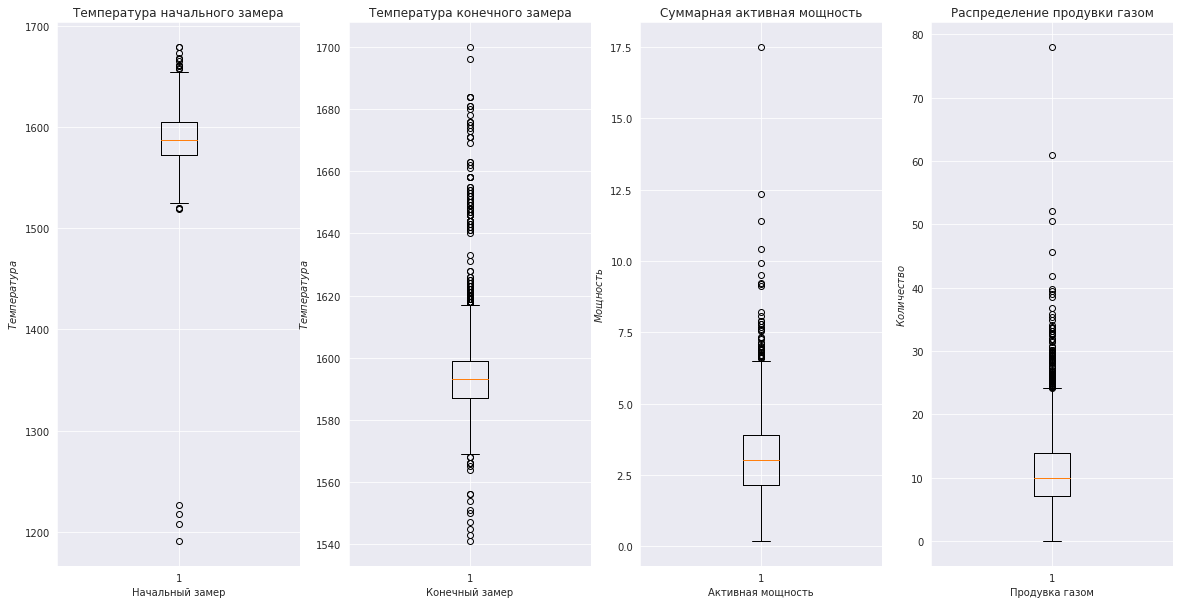

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(
    nrows=1, ncols=4,
    figsize=(20, 10)
)
 
ax1.boxplot(data_steel.start_temp)
ax1.set_title('Температура начального замера')
ax1.set_xlabel('Начальный замер')
ax1.set_ylabel('$Температура$')
 
ax2.boxplot(data_steel.end_temp)
ax2.set_title('Температура конечного замера')
ax2.set_xlabel('Конечный замер')
ax2.set_ylabel('$Температура$')
 
ax3.boxplot(data_steel.sum_active_power)
ax3.set_title('Суммарная активная мощность')
ax3.set_xlabel('Активная мощность')
ax3.set_ylabel('$Мощность$')
 
ax4.boxplot(data_steel.gas_1)
ax4.set_title('Распределение продувки газом')
ax4.set_xlabel('Продувка газом')
ax4.set_ylabel('$Количество$')

plt.show()

Выполним оценку мультиколлинеарности и отсутсвие зависимостей между целевым признаком и остальными.

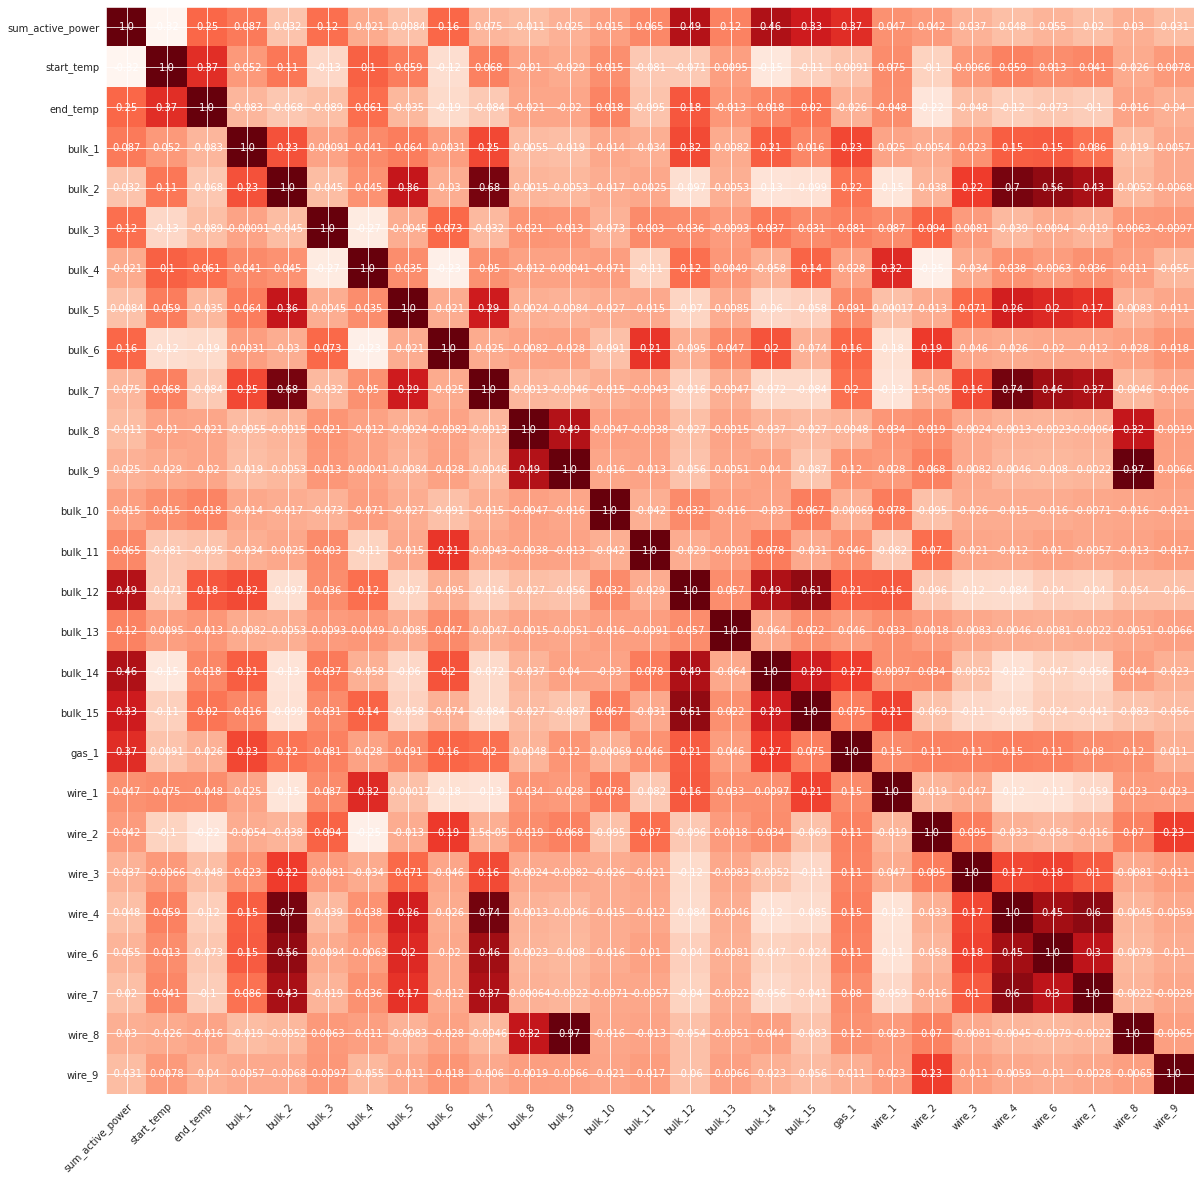

In [ ]:
data_steel_knn = data_steel.copy()
corr_heatmap_data = data_steel_knn.corr()

fig, ax = plt.subplots(figsize=(20,20))
ax.set_xticks(np.arange(len(corr_heatmap_data.index)))
ax.set_yticks(np.arange(len(corr_heatmap_data.index)))

ax.set_xticklabels(corr_heatmap_data.index)
ax.set_yticklabels(corr_heatmap_data.index)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

data = corr_heatmap_data.values

for i in range(len(corr_heatmap_data.index)):
    for j in range(len(corr_heatmap_data.index)):
        text = ax.text(j, i, '{:.2}'.format(data[i, j]),
                       ha="center", va="center", color="w")
        
im = ax.imshow(corr_heatmap_data.corr(), cmap='Reds')

Из heatmap видно что есть сильные прямопропоциональные зависимости между *bulk_9* и *wire_8*. Удалим из обучения *wire_8*.

In [ ]:
data_steel_knn = data_steel_knn.drop(['wire_8'], axis=1)

In [ ]:
# посмотрим, какие столбцы влияют на результат end_temp
data_steel_knn.corr()['end_temp'] 

sum_active_power    0.247650
start_temp          0.366398
end_temp            1.000000
bulk_1             -0.082638
bulk_2             -0.067612
bulk_3             -0.088806
bulk_4              0.061157
bulk_5             -0.034697
bulk_6             -0.188054
bulk_7             -0.084039
bulk_8             -0.021390
bulk_9             -0.020254
bulk_10             0.018222
bulk_11            -0.095105
bulk_12             0.180171
bulk_13            -0.012884
bulk_14             0.017625
bulk_15             0.019843
gas_1              -0.025723
wire_1             -0.048129
wire_2             -0.215639
wire_3             -0.048014
wire_4             -0.121044
wire_6             -0.073452
wire_7             -0.100990
wire_9             -0.039511
Name: end_temp, dtype: float64

Как видно, не все столбцы значимо влияют на данные. Для выявления аномалий возьмем те, чья корреляция больше 10%.

In [ ]:
data_steel_knn.corr()['end_temp'][data_steel_knn.corr()['end_temp'].abs() >= 0.1].index

Index(['sum_active_power', 'start_temp', 'end_temp', 'bulk_6', 'bulk_12',
       'wire_2', 'wire_4', 'wire_7'],
      dtype='object')

In [ ]:
model = KNN()
data_steel_have_anomaly = data_steel_knn[['sum_active_power',
                                          'start_temp',
                                          'end_temp',
                                          'bulk_6',
                                          'bulk_12',
                                          'wire_2',
                                          'wire_4',
                                          'wire_7']]
model.fit(data_steel_have_anomaly)
data_steel_have_anomaly['is_outlier'] =  model.predict(data_steel_have_anomaly) == 1
outliers_knn = data_steel_have_anomaly['is_outlier'].sum()
print(f'Количество аномалий (KNN): {outliers_knn}')

outlier_indexes = list(data_steel_have_anomaly[data_steel_have_anomaly['is_outlier'] == 1].index)
good_indexes = list(set(data_steel_have_anomaly.index) - set(outlier_indexes))

data_steel_knn = data_steel_knn.drop(outlier_indexes)
data_steel_knn.shape

Количество аномалий (KNN): 196


(2148, 26)

In [ ]:
del(corr_heatmap_data, model, data_steel_have_anomaly, outliers_knn, outlier_indexes, good_indexes)

## Вывод

---
Данные были подготовлены для обучения моделей.  
Целевым признаком является столбец **end_temp**. Остальные столбцы будут использованы для предсказания.

# Обучение моделей

Выберем следующие регрессоры для обучения модели:

- LinearRegression
- Ridge
- Lasso
- RandomForestRegressor
- CatBoostRegressor
- LGBMRegressor
- XGBRegressor

Также добавим константную модель, для проверки адекватности наших моделей.

In [ ]:
# разобьем данные на train и test к соотношению 75/25
features = data_steel_knn.drop('end_temp', axis=1)
target = data_steel_knn['end_temp']

features_train, features_test, target_train, target_test = train_test_split(
                                                            features, 
                                                            target, 
                                                            test_size=0.25, 
                                                            random_state=RANDOM_STATE)

folds = StratifiedKFold(n_splits=5,  shuffle=True, random_state=RANDOM_STATE)

In [ ]:
print('Размерность выборок')
for a in (features_train, features_test, target_train, target_test):
    print(a.shape)
del(a)    

Размерность выборок
(1611, 25)
(537, 25)
(1611,)
(537,)


Разделение выполнено верно.

## Линейная регрессия

In [ ]:
%%time

start_time = time.time()

regressor = LinearRegression()
print('MAE на train выборке')
print()
cv_mae_LR = (cross_val_score(regressor, 
                             features_train, 
                             target_train, 
                             cv=folds, 
                             scoring='neg_mean_absolute_error').mean() * -1) 

current_time = time.time()
cv_mae_LR_t = current_time-start_time
print(f'MAE модели на обучающей выборке = {cv_mae_LR}\n')

MAE на train выборке

MAE модели на обучающей выборке = 7.41927993606772

CPU times: user 37.9 ms, sys: 24.6 ms, total: 62.4 ms
Wall time: 50.9 ms


In [ ]:
%%time

start_time = time.time()

regressor = LinearRegression()
scaller = StandardScaler()
pipeline = Pipeline([("standard_scaller", scaller),("linear_regression", regressor)])
print('MAE на train выборке')
print()
cv_mae_LR_S = (cross_val_score(pipeline,
                                features_train, 
                                target_train, 
                                cv=folds, 
                                scoring='neg_mean_absolute_error').mean() * -1)
                                
current_time = time.time()
cv_mae_LR_S_t = current_time-start_time
print(f'MAE с использовнием StandardScaler = {cv_mae_LR_S}\n')

MAE на train выборке

MAE с использовнием StandardScaler = 7.419279936067729

CPU times: user 61.9 ms, sys: 59 ms, total: 121 ms
Wall time: 63.7 ms


Масштабирование признаков не сильно повлияло на модель.
Откажемся от применения масштаба.

In [ ]:
del(scaller, pipeline, cv_mae_LR_S, cv_mae_LR_S_t)

### Проведем обучение модели

In [ ]:
%%time

start_time = time.time()

model = LinearRegression()
model.fit(features_train, target_train)

current_time = time.time()
LR_fit_t = current_time-start_time

CPU times: user 6.72 ms, sys: 6.17 ms, total: 12.9 ms
Wall time: 9.16 ms


In [ ]:
%%time

start_time = time.time()

target_predict = model.predict(features_test)

current_time = time.time()
LR_predict_t = current_time-start_time

CPU times: user 3.02 ms, sys: 6.07 ms, total: 9.09 ms
Wall time: 6.69 ms


In [ ]:
final_mae_LR = mean_absolute_error(target_predict, target_test)
final_mae_LR

7.554381233301274

## Ridge

In [ ]:
%%time

start_time = time.time()

regressor = Ridge(random_state=RANDOM_STATE)
hyperparams = {'solver': ['auto', 'svd', 'cholesky', 'lsqr','sparse_cg'],
              'alpha': [ 0.0001 , 0.001 , 0.01 , 0.1 , 1 , 10 , 100 , 1000 , 10000 ]}

print('Подбор параметров для MAE\n')
clf = GridSearchCV(regressor, hyperparams, cv=folds, scoring='neg_mean_absolute_error')
clf.fit(features_train, target_train)
print(f'Лучший набор параметров, найденный в наборе:\n{clf.best_params_}\n\nGrid scores:\n')

means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print('%0.6f for %r'% ((mean*-1), params))
print()

cv_mae_R = (max(means)*-1)

current_time = time.time()
cv_mae_R_t = current_time-start_time
print(f'MAE модели на обучающей выборке = {cv_mae_R}\n')

Подбор параметров для MAE

Лучший набор параметров, найденный в наборе:
{'alpha': 100, 'solver': 'sparse_cg'}

Grid scores:

7.419280 for {'alpha': 0.0001, 'solver': 'auto'}
7.419280 for {'alpha': 0.0001, 'solver': 'svd'}
7.419280 for {'alpha': 0.0001, 'solver': 'cholesky'}
7.419083 for {'alpha': 0.0001, 'solver': 'lsqr'}
7.413091 for {'alpha': 0.0001, 'solver': 'sparse_cg'}
7.419279 for {'alpha': 0.001, 'solver': 'auto'}
7.419279 for {'alpha': 0.001, 'solver': 'svd'}
7.419279 for {'alpha': 0.001, 'solver': 'cholesky'}
7.419083 for {'alpha': 0.001, 'solver': 'lsqr'}
7.420281 for {'alpha': 0.001, 'solver': 'sparse_cg'}
7.419274 for {'alpha': 0.01, 'solver': 'auto'}
7.419274 for {'alpha': 0.01, 'solver': 'svd'}
7.419274 for {'alpha': 0.01, 'solver': 'cholesky'}
7.419078 for {'alpha': 0.01, 'solver': 'lsqr'}
7.413152 for {'alpha': 0.01, 'solver': 'sparse_cg'}
7.419216 for {'alpha': 0.1, 'solver': 'auto'}
7.419216 for {'alpha': 0.1, 'solver': 'svd'}
7.419216 for {'alpha': 0.1, 'solver': 'c

### Проведем обучение на модели с лучшими гиперпараметрами

In [ ]:
%%time

start_time = time.time()

model = Ridge(alpha=100, 
              solver='sparse_cg',
              random_state=RANDOM_STATE)
model.fit(features_train, target_train)

current_time = time.time()
R_fit_t = current_time-start_time

CPU times: user 14.7 ms, sys: 14.5 ms, total: 29.2 ms
Wall time: 19 ms


In [ ]:
%%time

start_time = time.time()

target_predict = model.predict(features_test)

current_time = time.time()
R_predict_t = current_time-start_time

CPU times: user 5.07 ms, sys: 8.04 ms, total: 13.1 ms
Wall time: 10.9 ms


In [ ]:
final_mae_R = mean_absolute_error(target_predict, target_test)
final_mae_R

7.5277882037701405

## Lasso

In [ ]:
%%time

start_time = time.time()

regressor = Lasso(normalize=True, random_state=RANDOM_STATE)
hyperparams = {'alpha': [0.0001 , 0.001 , 0.01 , 0.1 , 1 , 10 , 100 , 1000 , 10000],
               'max_iter': [500, 600, 700, 900, 1000, 1100],
               'selection': ['cyclic', 'random']}

print('Подбор параметров для MAE\n')
clf = GridSearchCV(regressor, hyperparams,cv=folds, scoring='neg_mean_absolute_error')
clf.fit(features_train, target_train)
print(f'Лучший набор параметров, найденный в наборе:\n{clf.best_params_}\n')
print('Grid scores:\n')
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print('%0.6f for %r'% ((mean*-1), params))
print()

cv_mae_L = (max(means)*-1) ** 0.5

current_time = time.time()
cv_mae_L_t = current_time-start_time
print(f'MAE модели на обучающей выборке = {cv_mae_L}\n')

Подбор параметров для MAE

Лучший набор параметров, найденный в наборе:
{'alpha': 0.01, 'max_iter': 500, 'selection': 'random'}

Grid scores:

7.415993 for {'alpha': 0.0001, 'max_iter': 500, 'selection': 'cyclic'}
7.415996 for {'alpha': 0.0001, 'max_iter': 500, 'selection': 'random'}
7.415993 for {'alpha': 0.0001, 'max_iter': 600, 'selection': 'cyclic'}
7.415996 for {'alpha': 0.0001, 'max_iter': 600, 'selection': 'random'}
7.415993 for {'alpha': 0.0001, 'max_iter': 700, 'selection': 'cyclic'}
7.415996 for {'alpha': 0.0001, 'max_iter': 700, 'selection': 'random'}
7.415993 for {'alpha': 0.0001, 'max_iter': 900, 'selection': 'cyclic'}
7.415996 for {'alpha': 0.0001, 'max_iter': 900, 'selection': 'random'}
7.415993 for {'alpha': 0.0001, 'max_iter': 1000, 'selection': 'cyclic'}
7.415996 for {'alpha': 0.0001, 'max_iter': 1000, 'selection': 'random'}
7.415993 for {'alpha': 0.0001, 'max_iter': 1100, 'selection': 'cyclic'}
7.415996 for {'alpha': 0.0001, 'max_iter': 1100, 'selection': 'random'}
7

### Проведем обучение на модели с лучшими гиперпараметрами

In [ ]:
%%time

start_time = time.time()

model =Lasso(alpha=0.01, 
             max_iter=500,
             selection='random',
             normalize=True,
             random_state=RANDOM_STATE)
model.fit(features_train, target_train)

current_time = time.time()
L_fit_t = current_time-start_time

CPU times: user 14.5 ms, sys: 4.13 ms, total: 18.6 ms
Wall time: 14.1 ms


In [ ]:
%%time

start_time = time.time()

target_predict = model.predict(features_test)

current_time = time.time()
L_predict_t = current_time-start_time

CPU times: user 6.4 ms, sys: 2.3 ms, total: 8.7 ms
Wall time: 7.21 ms


In [ ]:
final_mae_L = mean_absolute_error(target_predict, target_test)
final_mae_L

7.446677881222366

## RandomForestRegressor

In [ ]:
%%time

start_time = time.time()

regressor = RandomForestRegressor(criterion='mse', random_state=RANDOM_STATE)
hyperparams = {'n_estimators':[20, 50, 80, 100, 150, 200, 300, 350],
               'max_depth':[8, 10, 12,15, 20]}

print('Подбор параметров для MAE\n')
clf = GridSearchCV(regressor, hyperparams,cv=folds, scoring='neg_mean_absolute_error')
clf.fit(features_train, target_train)
print(f'Лучший набор параметров, найденный в наборе:\n{clf.best_params_}\n')
print('Grid scores:\n')
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print('%0.6f for %r'% ((mean*-1), params))
print()

cv_mae_RFR = (max(means)*-1)

current_time = time.time()
cv_mae_RFR_t = current_time-start_time
print(f'MAE модели на обучающей выборке = {cv_mae_RFR}\n')

Подбор параметров для MAE

Лучший набор параметров, найденный в наборе:
{'max_depth': 12, 'n_estimators': 300}

Grid scores:

5.912029 for {'max_depth': 8, 'n_estimators': 20}
5.845366 for {'max_depth': 8, 'n_estimators': 50}
5.824214 for {'max_depth': 8, 'n_estimators': 80}
5.809342 for {'max_depth': 8, 'n_estimators': 100}
5.805966 for {'max_depth': 8, 'n_estimators': 150}
5.809016 for {'max_depth': 8, 'n_estimators': 200}
5.793550 for {'max_depth': 8, 'n_estimators': 300}
5.794301 for {'max_depth': 8, 'n_estimators': 350}
5.907161 for {'max_depth': 10, 'n_estimators': 20}
5.801170 for {'max_depth': 10, 'n_estimators': 50}
5.776324 for {'max_depth': 10, 'n_estimators': 80}
5.768343 for {'max_depth': 10, 'n_estimators': 100}
5.760588 for {'max_depth': 10, 'n_estimators': 150}
5.757699 for {'max_depth': 10, 'n_estimators': 200}
5.741918 for {'max_depth': 10, 'n_estimators': 300}
5.739797 for {'max_depth': 10, 'n_estimators': 350}
5.837243 for {'max_depth': 12, 'n_estimators': 20}
5.775

### Проведем обучение на модели с лучшими гиперпараметрами

In [ ]:
%%time

start_time = time.time()

model = RandomForestRegressor(criterion = "mse",
                              random_state=RANDOM_STATE,
                              n_estimators = 300,
                              max_depth=12)
model.fit(features_train,target_train)

current_time = time.time()
RFR_fit_t = current_time-start_time

CPU times: user 2.19 s, sys: 7.79 ms, total: 2.2 s
Wall time: 2.19 s


In [ ]:
%%time

start_time = time.time()

target_predict = model.predict(features_test)

current_time = time.time()
RFR_predict_t = current_time-start_time

CPU times: user 61.7 ms, sys: 1.05 ms, total: 62.7 ms
Wall time: 60.9 ms


In [ ]:
final_mae_RFR = mean_absolute_error(target_predict, target_test)
final_mae_RFR

6.12411600712313

## CatBoostRegressor

In [ ]:
%%time

start_time = time.time()

regressor = CatBoostRegressor(iterations=200, random_state=RANDOM_STATE, verbose=False) 
hyperparams = {'learning_rate':[0.1, 0.5, 0.8]}

print('Подбор параметров для MAE\n')
clf = GridSearchCV(regressor, hyperparams,cv=folds, scoring='neg_mean_absolute_error')
clf.fit(features_train, target_train)
print(f'Лучший набор параметров, найденный в наборе:\n{clf.best_params_}\n')
print('Grid scores:\n')
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1), params))
print()

cv_mae_CBR = (max(means)*-1)

current_time = time.time()
cv_mae_CBR_t = current_time-start_time
print(f'RMSE модели для обучающей выборке = {cv_mae_CBR}\n')

Подбор параметров для MAE

Лучший набор параметров, найденный в наборе:
{'learning_rate': 0.1}

Grid scores:

5.648036 for {'learning_rate': 0.1}
6.256133 for {'learning_rate': 0.5}
6.878518 for {'learning_rate': 0.8}

RMSE модели для обучающей выборке = 5.648036099725381

CPU times: user 15.6 s, sys: 580 ms, total: 16.2 s
Wall time: 8.73 s


### Проведем обучение на модели с лучшими гиперпараметрами

In [ ]:
%%time

start_time = time.time()

win_model = CatBoostRegressor(learning_rate=0.1,
                          iterations = 200,
                          random_state=RANDOM_STATE, 
                          verbose=False)  
win_fit = win_model.fit(features_train, target_train)

current_time = time.time()
CBR_fit_t = current_time-start_time

CPU times: user 1.02 s, sys: 21.9 ms, total: 1.04 s
Wall time: 550 ms


In [ ]:
%%time

start_time = time.time()

target_predict = win_model.predict(features_test)

current_time = time.time()
CBR_predict_t = current_time-start_time

CPU times: user 4.12 ms, sys: 3 µs, total: 4.12 ms
Wall time: 5.91 ms


In [ ]:
final_mae_CBR = mean_absolute_error(target_predict, target_test)
final_mae_CBR

5.91280866346793

## LGBMRegressor

In [ ]:
%%time

start_time = time.time()

regressor = LGBMRegressor(random_state=RANDOM_STATE) 
hyperparams = {'num_leaves':[31, 100, 200], 
               'learning_rate':[0.1, 0.3, 0.5]}

print('Подбор параметров для MAE\n')
clf = GridSearchCV(regressor, hyperparams,cv=folds, scoring='neg_mean_absolute_error')
clf.fit(features_train, target_train)
print(f'Лучший набор параметров, найденный в наборе:\n{clf.best_params_}\n')
print('Grid scores:\n')
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1), params))
print()

cv_mae_LGBMR = (max(means)*-1)

current_time = time.time()
cv_mae_LGBMR_t = current_time-start_time
print(f'MAE модели для обучающей выборке = {cv_mae_LGBMR}\n')

Подбор параметров для MAE

Лучший набор параметров, найденный в наборе:
{'learning_rate': 0.1, 'num_leaves': 31}

Grid scores:

6.021387 for {'learning_rate': 0.1, 'num_leaves': 31}
6.031904 for {'learning_rate': 0.1, 'num_leaves': 100}
6.031904 for {'learning_rate': 0.1, 'num_leaves': 200}
6.506703 for {'learning_rate': 0.3, 'num_leaves': 31}
6.387002 for {'learning_rate': 0.3, 'num_leaves': 100}
6.387002 for {'learning_rate': 0.3, 'num_leaves': 200}
6.968294 for {'learning_rate': 0.5, 'num_leaves': 31}
6.751738 for {'learning_rate': 0.5, 'num_leaves': 100}
6.751738 for {'learning_rate': 0.5, 'num_leaves': 200}

MAE модели для обучающей выборке = 6.021387290676304

CPU times: user 13.3 s, sys: 784 ms, total: 14.1 s
Wall time: 7.25 s


### Проведем обучение на модели с лучшими гиперпараметрами

In [ ]:
%%time

start_time = time.time()

model = LGBMRegressor(learning_rate=0.1, 
                      num_leaves=31, 
                      random_state=RANDOM_STATE)  
model.fit(features_train, target_train)

current_time = time.time()
LGBMR_fit_t = current_time-start_time

CPU times: user 236 ms, sys: 21 ms, total: 257 ms
Wall time: 135 ms


In [ ]:
%%time

start_time = time.time()

target_predict = model.predict(features_test)

current_time = time.time()
LGBMR_predict_t = current_time-start_time

CPU times: user 8.83 ms, sys: 0 ns, total: 8.83 ms
Wall time: 4.46 ms


In [ ]:
final_mae_LGBMR = mean_absolute_error(target_predict, target_test)
final_mae_LGBMR

6.233554461474507

## XGBRegressor

In [ ]:
%%time

start_time = time.time()

regressor = XGBRegressor(random_state=RANDOM_STATE, silent=True) 
hyperparams = {'learning_rate':[x/100 for x in range(1, 51)]}

print('Подбор параметров для MAE\n')
clf = GridSearchCV(regressor, hyperparams,cv=folds, scoring='neg_mean_absolute_error')
clf.fit(features_train, target_train)
print(f'Лучший набор параметров, найденный в наборе:\n{clf.best_params_}\n')
print('Grid scores:\n')
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1), params))
print()

cv_mae_XGBR = (max(means)*-1)

current_time = time.time()
cv_mae_XGBR_t = current_time-start_time
print(f'MAE модели для обучающей выборке = {cv_mae_XGBR}\n')

Подбор параметров для MAE

Лучший набор параметров, найденный в наборе:
{'learning_rate': 0.16}

Grid scores:

584.360193 for {'learning_rate': 0.01}
211.919974 for {'learning_rate': 0.02}
76.215248 for {'learning_rate': 0.03}
27.250534 for {'learning_rate': 0.04}
10.412386 for {'learning_rate': 0.05}
6.456178 for {'learning_rate': 0.06}
5.835861 for {'learning_rate': 0.07}
5.743877 for {'learning_rate': 0.08}
5.719610 for {'learning_rate': 0.09}
5.764971 for {'learning_rate': 0.1}
5.720492 for {'learning_rate': 0.11}
5.705000 for {'learning_rate': 0.12}
5.715681 for {'learning_rate': 0.13}
5.747064 for {'learning_rate': 0.14}
5.723190 for {'learning_rate': 0.15}
5.673676 for {'learning_rate': 0.16}
5.804868 for {'learning_rate': 0.17}
5.819926 for {'learning_rate': 0.18}
5.794617 for {'learning_rate': 0.19}
5.856369 for {'learning_rate': 0.2}
5.812664 for {'learning_rate': 0.21}
5.785448 for {'learning_rate': 0.22}
5.816601 for {'learning_rate': 0.23}
5.833918 for {'learning_rate': 0.

### Проведем обучение на модели с лучшими гиперпараметрами

In [ ]:
%%time

start_time = time.time()

model = XGBRegressor(learning_rate=0.16, 
                     num_leaves=200, 
                     random_state=RANDOM_STATE)  
model.fit(features_train, target_train)

current_time = time.time()
XGBR_fit_t = current_time-start_time

[21:44:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 135 ms, sys: 6.01 ms, total: 141 ms
Wall time: 136 ms


In [ ]:
%%time

start_time = time.time()

target_predict = model.predict(features_test)

current_time = time.time()
XGBR_predict_t = current_time-start_time

CPU times: user 3.53 ms, sys: 19 µs, total: 3.55 ms
Wall time: 3.68 ms


In [ ]:
final_mae_XGBR = mean_absolute_error(target_predict, target_test)
final_mae_XGBR

6.047936

## Константная модель

In [ ]:
#Создаем константную модель
target_predict_constant = pd.Series([target_test.mean()]*len(target_test))
target_predict_constant.shape

(537,)

In [ ]:
final_mae_constant = mean_absolute_error(target_test, target_predict_constant)
final_mae_constant

10.00368278143629

# Анализ моделей

Создадим таблицу для сравнения параметров. 

Качественной оценкой будем считать выполнения двух условий:
- Минимальный показатель `МАЕ < 8.7`
- Желательный показатель `МАЕ < 6`

In [ ]:
index = ['LinearRegression',
         'Ridge',
         'Lasso',
         'RandomForestRegressor',
         'CatBoostRegressor',
         'LGBMRegressor',
         'XGBRegressor',
         'Константная модель']
data = {'MAE модели на обучающей выборке':[cv_mae_LR,
                                           cv_mae_R,
                                           cv_mae_L,
                                           cv_mae_RFR,
                                           cv_mae_CBR,
                                           cv_mae_LGBMR,
                                           cv_mae_XGBR,
                                           final_mae_constant],
        'Время подбора гиперпараметров, сек':[cv_mae_LR_t,
                                              cv_mae_R_t,
                                              cv_mae_L_t,
                                              cv_mae_RFR_t,
                                              cv_mae_CBR_t,
                                              cv_mae_LGBMR_t,
                                              cv_mae_XGBR_t,
                                              0.1],
        'MAE модели на тестовой выборке':[final_mae_LR,
                                          final_mae_R,
                                          final_mae_L,
                                          final_mae_RFR,
                                          final_mae_CBR,
                                          final_mae_LGBMR,
                                          final_mae_XGBR,
                                          final_mae_constant],
        'Время обучения модели, сек':[LR_fit_t,
                                      R_fit_t,
                                      L_fit_t,
                                      RFR_fit_t,
                                      CBR_fit_t,
                                      LGBMR_fit_t,
                                      XGBR_fit_t,
                                      0.1],
        'Время предсказания модели, сек':[LR_predict_t,
                                          R_predict_t,
                                          L_predict_t,
                                          RFR_predict_t,
                                          CBR_predict_t,
                                          LGBMR_predict_t,
                                          XGBR_predict_t,
                                          0.1]}

scores_data = pd.DataFrame(data=data, index=index)
scores_data['Рейтинг MAE'] = (scores_data['MAE модели на тестовой выборке'].min() /
                              scores_data['MAE модели на тестовой выборке'])
scores_data['Рейтинг времени обучения'] = (scores_data['Время обучения модели, сек'].min() / 
                              scores_data['Время обучения модели, сек'])
scores_data['Рейтинг времени предсказания'] = (scores_data['Время предсказания модели, сек'].min() / 
                              scores_data['Время предсказания модели, сек'])
scores_data['Итоговый рейтинг'] = (scores_data['Рейтинг MAE'] +
                                   scores_data['Рейтинг времени обучения'] +
                                   scores_data['Рейтинг времени предсказания'])

scores = []
for i in scores_data['MAE модели на тестовой выборке']:
  if i >8.7:
    scores.append('0 sp')
  if 7.6 < i <= 8.7:
    scores.append('4 sp')
  if 6.8 < i <= 7.6:
    scores.append('4.5 sp')
  if 6.3 < i <= 6.8:
    scores.append('5 sp')
  if 6.0 < i <= 6.3:
    scores.append('5.5 sp')
  if i <= 6.0:
    scores.append('6 sp')

scores_data['Метрика'] = scores
scores_data['Соответствие минимальному показателю'] = scores_data['MAE модели на тестовой выборке'] <= 6.8
scores_data['Соответствие желательному показателю'] = scores_data['MAE модели на тестовой выборке'] < 6

del(index, data, scores)
scores_data.sort_values(by='Метрика', ascending=False)

,MAE модели на обучающей выборке,"Время подбора гиперпараметров, сек",MAE модели на тестовой выборке,"Время обучения модели, сек","Время предсказания модели, сек",Рейтинг MAE,Рейтинг времени обучения,Рейтинг времени предсказания,Итоговый рейтинг,Метрика,Соответствие минимальному показателю,Соответствие желательному показателю
CatBoostRegressor,5.648036,8.731477,5.912809,0.549883,0.005894,1.000000,0.016630,0.621552,1.638181,6 sp,True,True
RandomForestRegressor,5.727568,208.101191,6.124116,2.191355,0.060881,0.965496,0.004173,0.060176,1.029844,5.5 sp,True,False
LGBMRegressor,6.021387,7.250985,6.233554,0.134530,0.004440,0.948545,0.067972,0.825109,1.841626,5.5 sp,True,False
XGBRegressor,5.673676,27.889117,6.047936,0.136137,0.003664,0.977657,0.067170,1.000000,2.044827,5.5 sp,True,False
LinearRegression,7.419280,0.050765,7.554381,0.009144,0.006679,0.782699,1.000000,0.548511,2.331211,4.5 sp,False,False
Ridge,7.377719,1.826469,7.527788,0.018944,0.010886,0.785464,0.482695,0.336531,1.604690,4.5 sp,False,False
Lasso,2.688975,4.233028,7.446678,0.014044,0.007199,0.794020,0.651127,0.508909,1.954056,4.5 sp,False,False
Константная модель,10.003683,0.100000,10.003683,0.100000,0.100000,0.591063,0.091443,0.036635,0.719142,0 sp,False,False


Были изучены 7 регрессионных и 1 константная моделей. Зафиксированы лучшие гиперпараметры и время их выполнения.

# Вывод

В ходе работы было выполнено:

- Загружены данные и проведена предобработка.
- Выполнено сравнение моделей с использованием различных наборов гиперпараметров.
- Выбрана лучшая модель по результатам метрики MAE.
- Для общей оценки по трем параметрам был создан относительный рейтинг.  
На выбор модели не влияло время обучения на кросвалидации, так как на одном типе данных ее проводят один раз. В то время переобучать модель на новых данных приходится намного чаще.
- Лучшие модели по итогам МАЕ:
  1. `CatBoostRegressor`    - 5.912809
  2. `XGBRegressor`        - 6.047936
  3. `RandomForestRegressor` - 6.124116
- Лучшей моделью по трем параметрам: качество, скорость обучения и скорость предсказания можно считать `LinearRegression`.  
Второе и третье места - `CatBoostRegressor` и `Lasso`.  
Но там разница идёт на доли секунд, поэтому этот рейтинг будет иметь значение лишь для больших объёмов данных.
---
Исходя из полученного рейтинга можно выделить специфику задач для регрессоров.

- Для быстрых решений с хорошей точностью подойдет `LinearRegression`.
- Если в деле важна точность - `CatBoostRegressor` поможет предсказать лучше всех.

Да, `LinearRegression` предсказывает просто молниеносно, но и `CatBoostRegressor` не сильно то отстаёт, но качество у неё заметно лучше.
В продакт можно смело рекомендовать `CatBoostRegressor`, так как разница во времени предсказания составляет всего доли секунд. Но если компания готова слегка пожертвовать предсказаний, и для неё гораздо важнее молниеносный ответ - то выбор стоит сделать в пользу `LinearRegression`.

# Отчёт

In [ ]:
win_parms = win_fit.get_all_params()
win_parms

{'nan_mode': 'Min',
 'eval_metric': 'RMSE',
 'iterations': 200,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'eval_fraction': 0,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': True,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': False,
 'random_seed': 8726,
 'depth': 6,
 'posterior_sampling': False,
 'border_count': 254,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'RMSE',
 'learning_rate': 0.10000000149011612,
 'score_function':

## Разброс предсказаний модели

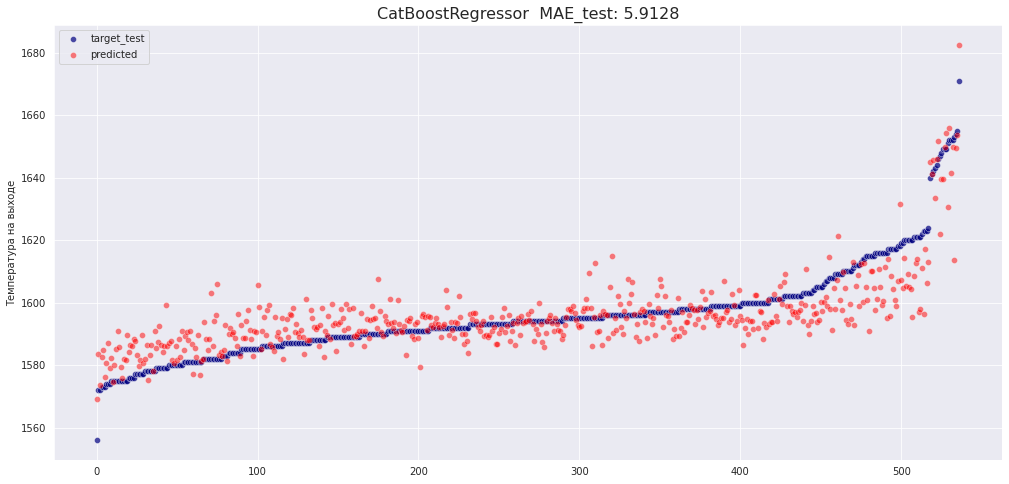

In [ ]:
df_result = pd.concat([target_test.reset_index(), 
                                   pd.Series(win_model.predict(features_test))], 
                                   axis=1).sort_values(by='end_temp').reset_index(drop=True)
df_result.columns=['key', 'Температура на выходе', 'temp_predicted']
plt.figure(figsize=[17,8])
sns.scatterplot(x=df_result.index, y=df_result['Температура на выходе'],  color='navy', alpha=0.7) 
sns.scatterplot(x=df_result.index, y=df_result['temp_predicted'],  color='red', alpha=0.5) 
plt.legend(['target_test', 'predicted'])

plt.title('CatBoostRegressor' + '  MAE_test: {:.4f}'.format(
            mean_absolute_error(target_test, win_model.predict(features_test))), fontsize=16);

del(df_result)

## График важности факторов

In [ ]:
# выбранная модель CatBoostRegressor с подобранными признаками
importances = win_model.feature_importances_  
features_results = pd.DataFrame({'Признаки': list(features_train.columns),'Важность': importances})  
# посмотрим на 10 самых важных
features_results = features_results.sort_values('Важность',ascending = False).reset_index(drop=True)  
features_results.head(10) 


,Признаки,Важность
0,start_temp,29.661178
1,wire_1,29.297528
2,sum_active_power,20.849805
3,gas_1,3.505347
4,bulk_14,2.683002
5,bulk_6,2.288964
6,bulk_15,2.102849
7,bulk_4,2.008190
8,bulk_12,2.001832
9,bulk_1,1.637675


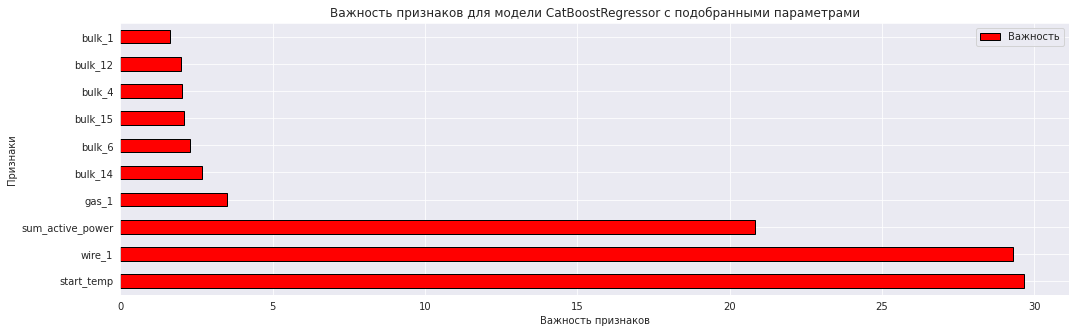

In [ ]:
features_results.head(10).plot(x = 'Признаки', y = 'Важность', kind = 'barh', color = 'red', edgecolor = 'black', figsize=(17, 5))

plt.xlabel('Важность признаков')
plt.title('Важность признаков для модели CatBoostRegressor с подобранными параметрами');

Самые важные признаки:
-  `start_temp` (начальная температура)
-  `wire_1`
- `sum_active_power` (суммарная активная мощность)

На них приходится больше 78 % суммарной важности. Уже у четвёртого признака `gas_1` важность сильно падает до 3,5%. Это может говорить о том, что нам не обязательно использовать все признака для достижения высокой точности прогнозирования.

План проекта выполнен полностью.

Ключевые этапы проекта:

- Ознакомительный этап
  - Ознакомление с доступной документацией о задаче, загрузка и первое знакомство с данными
  - Консультирование с тимлидом по поводу целей, требуемых метрик и особенностей техпроцесса
- Основной этап
  - Создание концепции отбора-создания признаков на основе информации о технологии процесса
  - Формирование базовой таблицы данных: объединение таблиц, фильтрация по временным меткам, создание набора дополнительных признаков для проверки разных гипотез
  - EDA анализ
  - Проверка корреляций с целевым параметром, мультиколлинеарности признаков и их отбор для модельного набора
  - Создание моделей предусмотренных планом, подбор гиперпараметров
  - Сравнение результатов разных моделей и важности признаков.

Итогом работы стала регрессия *CatBoostRegressor* – **MAE 5.912809**

## Ответы на вопросы

1. Какие пункты плана были выполнены, а какие — нет?

План был такой:
- [x] Загрузить данные.  
Выполнить исследовательский анализ и первичную предобработку.
- [x] Подготовить данные.  
Изменить типы данных, определить и использовать номера партий, у которых есть замеры по температуре.
- [x] Подготовить признаки.  
- [x] Проверить на мультиколлинеарность.
Составить единую таблицу со всеми данными для модели.
  - [x] Выделить целевой признак как последний замер в серии замеров. Разделить на features и target со смешиванием данных.
- [x] Выбрать модели.  
Использование и обучение регрессионных моделей.
- [x] Оценить эффективность моделей на тестовой выборке.
- [x] Составить сводную таблицу и выбрать лучшую модель.

*Все пунткты плана были выполнены*.
2. Какие трудности возникли и как вы их преодолели?

  - Не совсем просто было собрать признаки так, чтобы они были релевантны к целевому. Например, я не сразу заметил, что некоторые добавления материалов и нагревы происходили уже после последнего замера температуры. Пришлось возвращаться и избавляться от лишних значений

  - Долго не мог решить, какие признаки оставить для обучения модели: все или их часть, если часть - то какую. Проверив одинаковые модели на разных наборах features, стало ясно, что лучше использовать полный объем собранных признаков, после проверки на мультиколлинеарность.

3. Какие ключевые шаги в решении задачи выделили?

  - Загрузить данные, выполнить исследовательский анализ и первичную предобработку

  - Удалить из наборов данных партии, по которым у нас нет target-значения (последней измеренной температуры)

  - Создать достаточное количество признаков для каждой партии, по различным показателям - добавлению сыпучих материалов, добавлению проволочных материалов, нагревам и т.д.  
При этом начать лучше со вспомогательных (их потом удалить) - номер партии, время первого и последнего замера температуры, и потом остальные признаки собирать из сведений о манипуляциях, которые проводились именно в это время - до последнего замера.

  - Разделить полученный набор данных на *тренировочную* и *тестовую* выборки.  Разделить *признаки* и *целевой признак*

  - Обучить разные модели и выбрать лучшую по метрике MAE, используя кросс-валидацию.

  - Выбрать лучшую модель на тестовой выборке.

4. Какая ваша итоговая модель и какое у неё качество?

Лучшей моделью себя показал регрессор CatBoostRegressor с параметрами:

```python
{'auto_class_weights': 'None',
 'bayesian_matrix_reg': 0.10000000149011612,
 'best_model_min_trees': 1,
 'boost_from_average': True,
 'boosting_type': 'Plain',
 'bootstrap_type': 'MVS',
 'border_count': 254,
 'classes_count': 0,
 'depth': 6,
 'eval_metric': 'RMSE',
 'feature_border_type': 'GreedyLogSum',
 'force_unit_auto_pair_weights': False,
 'grow_policy': 'SymmetricTree',
 'iterations': 200,
 'l2_leaf_reg': 3,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'leaf_estimation_iterations': 1,
 'leaf_estimation_method': 'Newton',
 'learning_rate': 0.10000000149011612,
 'loss_function': 'RMSE',
 'max_leaves': 64,
 'min_data_in_leaf': 1,
 'model_shrink_mode': 'Constant',
 'model_shrink_rate': 0,
 'model_size_reg': 0.5,
 'nan_mode': 'Min',
 'penalties_coefficient': 1,
 'pool_metainfo_options': {'tags': {}},
 'posterior_sampling': False,
 'random_seed': 8726,
 'random_strength': 1,
 'rsm': 1,
 'sampling_frequency': 'PerTree',
 'score_function': 'Cosine',
 'sparse_features_conflict_fraction': 0,
 'subsample': 0.800000011920929,
 'task_type': 'CPU',
 'use_best_model': False}
```

**Показатель MAE на тестовой выборке: 5.91**